# Import

In [5]:
import os
import pandas as pd
import nibabel as nib
import numpy as np
import nilearn as nil
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from tqdm import tqdm
from scipy import ndimage
from sklearn.utils import class_weight
from sklearn.manifold import TSNE
from collections import Counter
from sklearn.metrics import confusion_matrix, silhouette_score, f1_score, roc_curve, auc, roc_auc_score, classification_report, accuracy_score, log_loss
import seaborn as sn
from sklearn.preprocessing import LabelBinarizer
from dltk.io.augmentation import *
from dltk.io.preprocessing import *
from numpy.random import seed
import SimpleITK as sitk
import warnings
warnings.filterwarnings("ignore")
from sklearn import metrics
import math
import random
import matplotlib.patheffects as PathEffects
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

In [6]:
from __future__ import absolute_import, division, print_function, unicode_literals
import six
from math import ceil
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Activation, Dense, Flatten, Lambda
from tensorflow.keras.layers import Conv3D, AveragePooling3D, MaxPooling3D
from tensorflow.keras.layers import add
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adadelta, Adam, SGD, Adagrad

In [7]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
      #  for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [8]:
ALPHA = 0.2
IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH, CHANNELS = (96, 96, 96, 1)
BUFFER_SIZE = 1000
BATCH_SIZE = 6

# Load Data

In [9]:
fold = "4"
data = pd.read_csv('D:\\Lab\\data\\combined_data.csv')
data_train = pd.read_csv('D:\\Lab\\data2/train_p0_fold_' + fold + '.csv')
data_val = pd.read_csv('D:\\Lab\\data2\\val_p0_fold_' + fold + '.csv')
data_test = pd.read_csv('D:\\Lab\\data2\\test_p0_fold_' + fold + '.csv')
# data = data.drop(['Format'], axis=11

In [10]:
data_train = data_train[data_train.Group != 'MCI']
data_val = data_val[data_val.Group != 'MCI']
data_test = data_test[data_test.Group != 'MCI']

In [11]:
data_val.head()

,Links,Group,Sex,Age,ETH,RACE
0,D:\Lab\ADNI\067_S_1185\MPR__GradWarp__B1_Corre...,AD,M,62,Not Hisp/Latino,White
1,D:\Lab\ADNI\067_S_1185\MPR__GradWarp__B1_Corre...,AD,M,62,Not Hisp/Latino,White
2,D:\Lab\ADNI\020_S_0213\MPR__GradWarp__B1_Corre...,AD,M,63,Not Hisp/Latino,Black
3,D:\Lab\ADNI\067_S_1185\MPR__GradWarp__B1_Corre...,AD,M,63,Not Hisp/Latino,White
4,D:\Lab\ADNI\067_S_1185\MPR__GradWarp__B1_Corre...,AD,M,63,Not Hisp/Latino,White


In [12]:
seed(1)

In [13]:
def get_id(l):
    return l.split('\\')[3]

get_id(data_train['Links'][0])

'073_S_1207'

In [14]:
sid_ad = set()
sid_cn = set()
for path in tqdm(data_train.to_numpy()):
    # print(idx)
    if path[1] == 'AD':
        sid_ad.add(get_id(path[0]))
    else:
        sid_cn.add(get_id(path[0]))

100%|█████████████████████████████████████████████████████████████████████████| 1025/1025 [00:00<00:00, 1025563.36it/s]


In [15]:
len(sid_ad), len(sid_cn)

(120, 140)

In [16]:
count = 0
for each in sid_ad:
    if each in sid_cn:
        count += 1
count

0

# Preprocess

In [17]:
def bbox(mask):
    r = np.any(mask, axis=(1, 2))
    c = np.any(mask, axis=(0, 2))
    z = np.any(mask, axis=(0, 1))

    rmin, rmax = np.where(r)[0][[0, -1]]
    cmin, cmax = np.where(c)[0][[0, -1]]
    zmin, zmax = np.where(z)[0][[0, -1]]
    
    return rmin, rmax, cmin, cmax, zmin, zmax

In [18]:
def resize_image_with_crop_or_pad(image, img_size=(64, 64, 64), **kwargs):
    """Image resizing. Resizes image by cropping or padding dimension
     to fit specified size.

    Args:
        image (np.ndarray): image to be resized
        img_size (list or tuple): new image size
        kwargs (): additional arguments to be passed to np.pad

    Returns:
        np.ndarray: resized image
    """

    assert isinstance(image, (np.ndarray, np.generic))
    assert (image.ndim - 1 == len(img_size) or image.ndim == len(img_size)), \
        'Example size doesnt fit image size'

    # Get the image dimensionality
    rank = len(img_size)

    # Create placeholders for the new shape
    from_indices = [[0, image.shape[dim]] for dim in range(rank)]
    to_padding = [[0, 0] for dim in range(rank)]

    slicer = [slice(None)] * rank

    # For each dimensions find whether it is supposed to be cropped or padded
    for i in range(rank):
        if image.shape[i] < img_size[i]:
            to_padding[i][0] = (img_size[i] - image.shape[i]) // 2
            to_padding[i][1] = img_size[i] - image.shape[i] - to_padding[i][0]
        else:
            from_indices[i][0] = int(np.floor((image.shape[i] - img_size[i]) / 2.))
            from_indices[i][1] = from_indices[i][0] + img_size[i]

        # Create slicer object to crop or leave each dimension
        slicer[i] = slice(from_indices[i][0], from_indices[i][1])

    # Pad the cropped image to extend the missing dimension
    return np.pad(image[slicer[0],slicer[1],slicer[2]], to_padding, **kwargs)

In [19]:
mask1_folder = 'D:\\Lab\\hippo'
mask2_folder = 'D:\\Lab\\amygdala'
mask_folder = 'D:\\Lab\\hippo'
def apply_mask(filename):
    
    folder = filename.split('\\')
    image_name = folder[-1]
    # mask_name = mask_folder +'\\w'+ image_name.split('.')[0][2:] + 'hippo_mask.nii'
    mask1_name = mask1_folder +'\\w'+ image_name.split('.')[0][2:] + 'hippo_mask.nii'
    mask2_name = mask2_folder +'\\w'+ image_name.split('.')[0][2:] + 'amygdala.nii'
    
    sitk_img = sitk.ReadImage(filename)
    img = sitk.GetArrayFromImage(sitk_img)

    sitk_mask1 = sitk.ReadImage(mask1_name)
    sitk_mask1 = sitk.Resample(sitk_mask1, sitk_img, sitk.Transform(), sitk.sitkNearestNeighbor, 0, sitk_mask1.GetPixelID()) 
    mask_img1 = sitk.GetArrayFromImage(sitk_mask1)
    
    # sitk_mask2 = sitk.ReadImage(mask2_name)
    # sitk_mask2 = sitk.Resample(sitk_mask2, sitk_img, sitk.Transform(), sitk.sitkNearestNeighbor, 0, sitk_mask2.GetPixelID())
    # mask_img2 = sitk.GetArrayFromImage(sitk_mask2)
   
    img = np.swapaxes(img, 0,2)
    mask_img1 = np.swapaxes(mask_img1, 0,2)
    mask_img1 = ndimage.binary_dilation(mask_img1, iterations=2)
    # mask_img2 = np.swapaxes(mask_img2, 0,2)
    
    rmin, rmax, cmin, cmax, zmin, zmax = bbox(img)
    img = img[rmin:rmax, cmin:cmax, zmin:zmax]
    # rmin, rmax, cmin, cmax, zmin, zmax = bbox(mask_img)
    mask_img1 = mask_img1[rmin:rmax, cmin:cmax, zmin:zmax]
    # mask_img2 = mask_img2[rmin:rmax, cmin:cmax, zmin:zmax]
    
    r,c,z = img.shape
    diff_r, diff_c, diff_z = r-IMAGE_HEIGHT, c-IMAGE_WIDTH, z-IMAGE_DEPTH
    # new_img = img
    if diff_r > 0:
        img = img[diff_r//2:r-diff_r//2,:,:]
        mask_img1 = mask_img1[diff_r//2:r-diff_r//2,:,:]
        # mask_img2 = mask_img2[diff_r//2:r-diff_r//2,:,:]
    if diff_c > 0:
        img = img[:,diff_c//2:c-diff_c//2,:]
        mask_img1 = mask_img1[:,diff_c//2:c-diff_c//2,:]
        # mask_img2 = mask_img2[:,diff_c//2:c-diff_c//2,:]
    if diff_z > 0:
        img = img[:,:,diff_z//2:z-diff_z//2]
        mask_img1 = mask_img1[:,:,diff_z//2:z-diff_z//2]
        # mask_img2 = mask_img2[:,:,diff_z//2:z-diff_z//2]
    img = resize_image_with_crop_or_pad(img, (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH))
    mask_img1 = resize_image_with_crop_or_pad(mask_img1, (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH))
    # mask_img2 = resize_image_with_crop_or_pad(mask_img2, (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH))
    
    return img, mask_img1
    # return {'inputImg':images, 'inputMask': mask_img1}

def apply_mask_train(filename, labels):
    # name = tf.strings.split(filename, sep= '\\')
    # masked_filename = name[:-1]
    # image_name = name[-1]
    # masked_filename = '\\'.join(masked_filename) + '\\Masked.nii'
    # masked_filename = tf.strings.join(masked_filename, separator='\\') +'\\c1' + image_name
    # print(masked_filename)
    
    folder = tf.strings.split(filename, sep= '\\')
    image_name = folder[-1]
    image_name = tf.strings.split(image_name, sep= '.')[0]
    # mask_name = tf.strings.join(folder[:-1], separator='\\') +'\\'+ image_name + '_mask.nii'
    image_name = tf.strings.substr(image_name, pos=2, len=tf.strings.length(image_name)-2)
    mask1_name = mask1_folder +'\\w'+ image_name + 'hippo_mask.nii'
    mask2_name = mask2_folder +'\\w'+ image_name + 'amygdala.nii'
    
    # if os.path.exists(mask_name.numpy().decode()):
    #     pass
    # else:
    #     image_name = tf.strings.substr(image_name, pos=2, len=tf.strings.length(image_name)-2)
    #     mask_name =  tf.strings.join(folder[:-2], separator='\\') + '\\' + image_name + '_mask.nii'
    
    sitk_img = sitk.ReadImage(filename.numpy().decode())
    img = sitk.GetArrayFromImage(sitk_img)

    sitk_mask1 = sitk.ReadImage(mask1_name.numpy().decode())
    sitk_mask1 = sitk.Resample(sitk_mask1, sitk_img, sitk.Transform(), sitk.sitkNearestNeighbor, 0, sitk_mask1.GetPixelID()) 
    mask_img1 = sitk.GetArrayFromImage(sitk_mask1)
    
    sitk_mask2 = sitk.ReadImage(mask2_name.numpy().decode())
    sitk_mask2 = sitk.Resample(sitk_mask2, sitk_img, sitk.Transform(), sitk.sitkNearestNeighbor, 0, sitk_mask2.GetPixelID()) 
    mask_img2 = sitk.GetArrayFromImage(sitk_mask2)
    
    img = np.swapaxes(img, 0,2)
    mask_img1 = np.swapaxes(mask_img1, 0,2)
    mask_img2 = np.swapaxes(mask_img2, 0,2)
    
    rmin, rmax, cmin, cmax, zmin, zmax = bbox(img)
    img = img[rmin:rmax, cmin:cmax, zmin:zmax]
    # rmin, rmax, cmin, cmax, zmin, zmax = bbox(mask_img)
    mask_img1 = mask_img1[rmin:rmax, cmin:cmax, zmin:zmax]
    mask_img2 = mask_img2[rmin:rmax, cmin:cmax, zmin:zmax]
    
    r,c,z = img.shape
    diff_r, diff_c, diff_z = r-IMAGE_HEIGHT, c-IMAGE_WIDTH, z-IMAGE_DEPTH
    # new_img = img
    if diff_r > 0:
        img = img[diff_r//2:r-diff_r//2,:,:]
        mask_img1 = mask_img1[diff_r//2:r-diff_r//2,:,:]
        mask_img2 = mask_img2[diff_r//2:r-diff_r//2,:,:]
    if diff_c > 0:
        img = img[:,diff_c//2:c-diff_c//2,:]
        mask_img1 = mask_img1[:,diff_c//2:c-diff_c//2,:]
        mask_img2 = mask_img2[:,diff_c//2:c-diff_c//2,:]
    if diff_z > 0:
        img = img[:,:,diff_z//2:z-diff_z//2]
        mask_img1 = mask_img1[:,:,diff_z//2:z-diff_z//2]
        mask_img2 = mask_img2[:,:,diff_z//2:z-diff_z//2]
        
#     r,c,z = mask_img.shape
#     diff_r, diff_c, diff_z = r-MASK_HEIGHT, c-MASK_WIDTH, z-MASK_DEPTH
#     # new_img = img
#     if diff_r > 0:
#         # img = img[diff_r//2:r-diff_r//2,:,:]
#         mask_img = mask_img[diff_r//2:r-diff_r//2,:,:]
#     if diff_c > 0:
#         # img = img[:,diff_c//2:c-diff_c//2,:]
#         mask_img = mask_img[:,diff_c//2:c-diff_c//2,:]
#     if diff_z > 0:
#         # img = img[:,:,diff_z//2:z-diff_z//2]
#         mask_img = mask_img[:,:,diff_z//2:z-diff_z//2]
        
    img = resize_image_with_crop_or_pad(img, (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH))
    mask_img1 = resize_image_with_crop_or_pad(mask_img1, (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH))
    mask_img2 = resize_image_with_crop_or_pad(mask_img2, (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH))
#     mask_img = resize_image_with_crop_or_pad(mask_img, (MASK_HEIGHT, MASK_WIDTH, MASK_DEPTH))
    
    # img = nib.load(filename.numpy().decode()).get_fdata()
    # rmin, rmax, cmin, cmax, zmin, zmax = bbox(img)
    # img = img[rmin:rmax, cmin:cmax, zmin:zmax]
    # r,c,z = img.shape
    # diff_r, diff_c, diff_z = r-IMAGE_HEIGHT, c-IMAGE_WIDTH, z-IMAGE_DEPTH
    # # new_img = img
    # if diff_r > 0:
    #     img = img[diff_r//2:r-diff_r//2,:,:]
    # if diff_c > 0:
    #     img = img[:,diff_c//2:c-diff_c//2,:]
    # if diff_z > 0:
    #     img = img[:,:,diff_z//2:z-diff_z//2]
    # img = resize_image_with_crop_or_pad(img, (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH))
    img = tf.convert_to_tensor(img, dtype=tf.float32)
    mask_img1 = tf.convert_to_tensor(mask_img1, dtype=tf.float32)
    mask_img2 = tf.convert_to_tensor(mask_img2, dtype=tf.float32)
    labels = tf.convert_to_tensor(labels, dtype=tf.int32)
    return img, mask_img1, mask_img2, labels

def apply_mask_val(filename):
    # name = tf.strings.split(filename, sep= '\\')
    # masked_filename = name[:-1]
    # image_name = name[-1]
    # masked_filename = '\\'.join(masked_filename) + '\\Masked.nii'
    # m
    # asked_filename = tf.strings.join(masked_filename, separator='\\') +'\\c1' + image_name
    # print(masked_filename)
    
    folder = tf.strings.split(filename, sep= '\\')
    image_name = folder[-1]
    image_name = tf.strings.split(image_name, sep= '.')[0]
    image_name = tf.strings.substr(image_name, pos=2, len=tf.strings.length(image_name)-2)
    mask_name = mask_folder +'\\w'+ image_name + 'hippo_mask.nii'
    # mask_name = mask_folder +'\\w'+ image_name + 'amygdala.nii'
    # print(mask_name)
    
    sitk_img = sitk.ReadImage(filename)
    img = sitk.GetArrayFromImage(sitk_img)

    sitk_mask = sitk.ReadImage(mask_name.numpy().decode())
    mask_img = sitk.GetArrayFromImage(sitk_mask)
    resampled_img = sitk.Resample(sitk_mask, sitk_img, sitk.Transform(), sitk.sitkNearestNeighbor, 0, sitk_mask.GetPixelID())
    
    output_spacing = sitk_img.GetSpacing()
    output_size = [int(IMAGE_DEPTH/output_spacing[0]), int(IMAGE_WIDTH/output_spacing[1]),int( IMAGE_HEIGHT/output_spacing[2])]
    
    # mask_img = sitk.GetArrayFromImage(resampled_img)
    img = sitk.GetArrayFromImage(sitk_img)
    
    img = np.swapaxes(img, 0,2)
    mask_img = np.swapaxes(mask_img, 0,2)
    mask_img = ndimage.binary_dilation(mask_img, iterations = 2)
    
    rmin, rmax, cmin, cmax, zmin, zmax = bbox(img)
    img = img[rmin:rmax, cmin:cmax, zmin:zmax]
    # rmin, rmax, cmin, cmax, zmin, zmax = bbox(mask_img)
    mask_img = mask_img[rmin:rmax, cmin:cmax, zmin:zmax]
    
    r,c,z = img.shape
    diff_r, diff_c, diff_z = r-IMAGE_HEIGHT, c-IMAGE_WIDTH, z-IMAGE_DEPTH
    # new_img = img
    if diff_r > 0:
        img = img[diff_r//2:r-diff_r//2,:,:]
        mask_img = mask_img[diff_r//2:r-diff_r//2,:,:]
    if diff_c > 0:
        img = img[:,diff_c//2:c-diff_c//2,:]
        mask_img = mask_img[:,diff_c//2:c-diff_c//2,:]
    if diff_z > 0:
        img = img[:,:,diff_z//2:z-diff_z//2]
        mask_img = mask_img[:,:,diff_z//2:z-diff_z//2]

    img = resize_image_with_crop_or_pad(img, (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH))
    mask_img = resize_image_with_crop_or_pad(mask_img, (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH))

    img = tf.convert_to_tensor(img, dtype=tf.float32)
    mask_img = tf.convert_to_tensor(mask_img, dtype=tf.float32)
    # labels = tf.convert_to_tensor(labels, dtype=tf.int32)
    return img

def apply_mask_classifier(filename, labels):
    folder = tf.strings.split(filename, sep= '\\')
    image_name = folder[-1]
    image_name = tf.strings.split(image_name, sep= '.')[0]
    image_name = tf.strings.substr(image_name, pos=2, len=tf.strings.length(image_name)-2)
    
    sitk_img = sitk.ReadImage(filename.numpy().decode())
    img = sitk.GetArrayFromImage(sitk_img)
    
    img = np.swapaxes(img, 0,2)
    
    rmin, rmax, cmin, cmax, zmin, zmax = bbox(img)
    img = img[rmin:rmax, cmin:cmax, zmin:zmax]
    
    r,c,z = img.shape
    diff_r, diff_c, diff_z = r-IMAGE_HEIGHT, c-IMAGE_WIDTH, z-IMAGE_DEPTH
    # new_img = img
    if diff_r > 0:
        img = img[diff_r//2:r-diff_r//2,:,:]
    if diff_c > 0:
        img = img[:,diff_c//2:c-diff_c//2,:]
    if diff_z > 0:
        img = img[:,:,diff_z//2:z-diff_z//2]

    img = resize_image_with_crop_or_pad(img, (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH))

    img = tf.convert_to_tensor(img, dtype=tf.float32)
    labels = tf.convert_to_tensor(labels, dtype=tf.int32)
    return img, labels

def wrapper_train(filename, labels):
    img, mask_img1, mask_img2, label = tf.py_function(apply_mask_train, [filename, labels], [tf.float32, tf.float32, tf.float32, tf.int32])
    return img, mask_img1, mask_img2, label

def wrapper_val(filename, labels):
    img, label = tf.py_function(apply_mask_classifier, [filename, labels], [tf.float32, tf.int32])
    return img, label

In [20]:
# mask1_folder = 'D:\\Lab\\hippo'
# mask2_folder = 'D:\\Lab\\amygdala'
# mask_folder = 'D:\\Lab\\hippo'
# def apply_mask(filename):
    
#     folder = filename.split('\\')
#     image_name = folder[-1]
#     # mask_name = mask_folder +'\\w'+ image_name.split('.')[0][2:] + 'hippo_mask.nii'
#     mask1_name = mask1_folder +'\\w'+ image_name.split('.')[0][2:] + 'hippo_mask.nii'
#     mask2_name = mask2_folder +'\\w'+ image_name.split('.')[0][2:] + 'amygdala.nii'
    
#     sitk_img = sitk.ReadImage(filename)
#     img = sitk.GetArrayFromImage(sitk_img)

#     sitk_mask1 = sitk.ReadImage(mask1_name)
#     sitk_mask1 = sitk.Resample(sitk_mask1, sitk_img, sitk.Transform(), sitk.sitkNearestNeighbor, 0, sitk_mask1.GetPixelID()) 
#     mask_img1 = sitk.GetArrayFromImage(sitk_mask1)
    
#     # sitk_mask2 = sitk.ReadImage(mask2_name)
#     # sitk_mask2 = sitk.Resample(sitk_mask2, sitk_img, sitk.Transform(), sitk.sitkNearestNeighbor, 0, sitk_mask2.GetPixelID())
#     # mask_img2 = sitk.GetArrayFromImage(sitk_mask2)
   
#     img = np.swapaxes(img, 0,2)
#     mask_img1 = np.swapaxes(mask_img1, 0,2)
#     mask_img1 = ndimage.binary_dilation(mask_img1, iterations=2)
#     # mask_img2 = np.swapaxes(mask_img2, 0,2)
    
#     rmin, rmax, cmin, cmax, zmin, zmax = bbox(img)
#     img = img[rmin:rmax, cmin:cmax, zmin:zmax]
#     # rmin, rmax, cmin, cmax, zmin, zmax = bbox(mask_img)
#     mask_img1 = mask_img1[rmin:rmax, cmin:cmax, zmin:zmax]
#     # mask_img2 = mask_img2[rmin:rmax, cmin:cmax, zmin:zmax]
    
#     r,c,z = img.shape
#     diff_r, diff_c, diff_z = r-IMAGE_HEIGHT, c-IMAGE_WIDTH, z-IMAGE_DEPTH
#     # new_img = img
#     if diff_r > 0:
#         img = img[diff_r//2:r-diff_r//2,:,:]
#         mask_img1 = mask_img1[diff_r//2:r-diff_r//2,:,:]
#         # mask_img2 = mask_img2[diff_r//2:r-diff_r//2,:,:]
#     if diff_c > 0:
#         img = img[:,diff_c//2:c-diff_c//2,:]
#         mask_img1 = mask_img1[:,diff_c//2:c-diff_c//2,:]
#         # mask_img2 = mask_img2[:,diff_c//2:c-diff_c//2,:]
#     if diff_z > 0:
#         img = img[:,:,diff_z//2:z-diff_z//2]
#         mask_img1 = mask_img1[:,:,diff_z//2:z-diff_z//2]
#         # mask_img2 = mask_img2[:,:,diff_z//2:z-diff_z//2]
#     img = resize_image_with_crop_or_pad(img, (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH))
#     mask_img1 = resize_image_with_crop_or_pad(mask_img1, (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH))
#     # mask_img2 = resize_image_with_crop_or_pad(mask_img2, (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH))
    
#     return img, mask_img1
#     # return {'inputImg':images, 'inputMask': mask_img1}

# def apply_mask_train(filename, labels):
#     # name = tf.strings.split(filename, sep= '\\')
#     # masked_filename = name[:-1]
#     # image_name = name[-1]
#     # masked_filename = '\\'.join(masked_filename) + '\\Masked.nii'
#     # masked_filename = tf.strings.join(masked_filename, separator='\\') +'\\c1' + image_name
#     # print(masked_filename)
    
#     folder = tf.strings.split(filename, sep= '\\')
#     image_name = folder[-1]
#     image_name = tf.strings.split(image_name, sep= '.')[0]
#     # mask_name = tf.strings.join(folder[:-1], separator='\\') +'\\'+ image_name + '_mask.nii'
#     image_name = tf.strings.substr(image_name, pos=2, len=tf.strings.length(image_name)-2)
#     mask1_name = mask1_folder +'\\w'+ image_name + 'hippo_mask.nii'
#     mask2_name = mask2_folder +'\\w'+ image_name + 'amygdala.nii'
    
#     # if os.path.exists(mask_name.numpy().decode()):
#     #     pass
#     # else:
#     #     image_name = tf.strings.substr(image_name, pos=2, len=tf.strings.length(image_name)-2)
#     #     mask_name =  tf.strings.join(folder[:-2], separator='\\') + '\\' + image_name + '_mask.nii'
    
#     sitk_img = sitk.ReadImage(filename.numpy().decode())
#     img = sitk.GetArrayFromImage(sitk_img)

#     sitk_mask1 = sitk.ReadImage(mask1_name.numpy().decode())
#     sitk_mask1 = sitk.Resample(sitk_mask1, sitk_img, sitk.Transform(), sitk.sitkNearestNeighbor, 0, sitk_mask1.GetPixelID()) 
#     mask_img1 = sitk.GetArrayFromImage(sitk_mask1)
    
#     sitk_mask2 = sitk.ReadImage(mask2_name.numpy().decode())
#     sitk_mask2 = sitk.Resample(sitk_mask2, sitk_img, sitk.Transform(), sitk.sitkNearestNeighbor, 0, sitk_mask2.GetPixelID()) 
#     mask_img2 = sitk.GetArrayFromImage(sitk_mask2)
    
#     img = np.swapaxes(img, 0,2)
#     mask_img1 = np.swapaxes(mask_img1, 0,2)
#     mask_img2 = np.swapaxes(mask_img2, 0,2)
    
#     rmin, rmax, cmin, cmax, zmin, zmax = bbox(img)
#     img = img[rmin:rmax, cmin:cmax, zmin:zmax]
#     # rmin, rmax, cmin, cmax, zmin, zmax = bbox(mask_img)
#     mask_img1 = mask_img1[rmin:rmax, cmin:cmax, zmin:zmax]
#     mask_img2 = mask_img2[rmin:rmax, cmin:cmax, zmin:zmax]
    
#     r,c,z = img.shape
#     diff_r, diff_c, diff_z = r-IMAGE_HEIGHT, c-IMAGE_WIDTH, z-IMAGE_DEPTH
#     # new_img = img
#     if diff_r > 0:
#         img = img[diff_r//2:r-diff_r//2,:,:]
#         mask_img1 = mask_img1[diff_r//2:r-diff_r//2,:,:]
#         mask_img2 = mask_img2[diff_r//2:r-diff_r//2,:,:]
#     if diff_c > 0:
#         img = img[:,diff_c//2:c-diff_c//2,:]
#         mask_img1 = mask_img1[:,diff_c//2:c-diff_c//2,:]
#         mask_img2 = mask_img2[:,diff_c//2:c-diff_c//2,:]
#     if diff_z > 0:
#         img = img[:,:,diff_z//2:z-diff_z//2]
#         mask_img1 = mask_img1[:,:,diff_z//2:z-diff_z//2]
#         mask_img2 = mask_img2[:,:,diff_z//2:z-diff_z//2]
        
# #     r,c,z = mask_img.shape
# #     diff_r, diff_c, diff_z = r-MASK_HEIGHT, c-MASK_WIDTH, z-MASK_DEPTH
# #     # new_img = img
# #     if diff_r > 0:
# #         # img = img[diff_r//2:r-diff_r//2,:,:]
# #         mask_img = mask_img[diff_r//2:r-diff_r//2,:,:]
# #     if diff_c > 0:
# #         # img = img[:,diff_c//2:c-diff_c//2,:]
# #         mask_img = mask_img[:,diff_c//2:c-diff_c//2,:]
# #     if diff_z > 0:
# #         # img = img[:,:,diff_z//2:z-diff_z//2]
# #         mask_img = mask_img[:,:,diff_z//2:z-diff_z//2]
        
#     img = resize_image_with_crop_or_pad(img, (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH))
#     mask_img1 = resize_image_with_crop_or_pad(mask_img1, (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH))
#     mask_img2 = resize_image_with_crop_or_pad(mask_img2, (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH))
# #     mask_img = resize_image_with_crop_or_pad(mask_img, (MASK_HEIGHT, MASK_WIDTH, MASK_DEPTH))
    
#     # img = nib.load(filename.numpy().decode()).get_fdata()
#     # rmin, rmax, cmin, cmax, zmin, zmax = bbox(img)
#     # img = img[rmin:rmax, cmin:cmax, zmin:zmax]
#     # r,c,z = img.shape
#     # diff_r, diff_c, diff_z = r-IMAGE_HEIGHT, c-IMAGE_WIDTH, z-IMAGE_DEPTH
#     # # new_img = img
#     # if diff_r > 0:
#     #     img = img[diff_r//2:r-diff_r//2,:,:]
#     # if diff_c > 0:
#     #     img = img[:,diff_c//2:c-diff_c//2,:]
#     # if diff_z > 0:
#     #     img = img[:,:,diff_z//2:z-diff_z//2]
#     # img = resize_image_with_crop_or_pad(img, (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH))
#     img = tf.convert_to_tensor(img, dtype=tf.float32)
#     mask_img1 = tf.convert_to_tensor(mask_img1, dtype=tf.float32)
#     mask_img2 = tf.convert_to_tensor(mask_img2, dtype=tf.float32)
#     labels = tf.convert_to_tensor(labels, dtype=tf.int32)
#     return img, mask_img1, mask_img2, labels

# def apply_mask_val(filename):
#     # name = tf.strings.split(filename, sep= '\\')
#     # masked_filename = name[:-1]
#     # image_name = name[-1]
#     # masked_filename = '\\'.join(masked_filename) + '\\Masked.nii'
#     # m
#     # asked_filename = tf.strings.join(masked_filename, separator='\\') +'\\c1' + image_name
#     # print(masked_filename)
    
#     folder = tf.strings.split(filename, sep= '\\')
#     image_name = folder[-1]
#     image_name = tf.strings.split(image_name, sep= '.')[0]
#     image_name = tf.strings.substr(image_name, pos=2, len=tf.strings.length(image_name)-2)
#     # mask_name = mask_folder +'\\w'+ image_name + 'hippo_mask.nii'
#     # mask_name = mask_folder +'\\w'+ image_name + 'amygdala.nii'
#     # print(mask_name)
    
#     sitk_img = sitk.ReadImage(filename)
#     img = sitk.GetArrayFromImage(sitk_img)

#     # sitk_mask = sitk.ReadImage(mask_name.numpy().decode())
#     # mask_img = sitk.GetArrayFromImage(sitk_mask)
#     # resampled_img = sitk.Resample(sitk_mask, sitk_img, sitk.Transform(), sitk.sitkNearestNeighbor, 0, sitk_mask.GetPixelID())
    
#     output_spacing = sitk_img.GetSpacing()
#     output_size = [int(IMAGE_DEPTH/output_spacing[0]), int(IMAGE_WIDTH/output_spacing[1]),int( IMAGE_HEIGHT/output_spacing[2])]
    
#     # mask_img = sitk.GetArrayFromImage(resampled_img)
#     img = sitk.GetArrayFromImage(sitk_img)
    
#     img = np.swapaxes(img, 0,2)
#     # mask_img = np.swapaxes(mask_img, 0,2)
#     # mask_img = ndimage.binary_dilation(mask_img, iterations = 2)
    
#     rmin, rmax, cmin, cmax, zmin, zmax = bbox(img)
#     img = img[rmin:rmax, cmin:cmax, zmin:zmax]
#     # rmin, rmax, cmin, cmax, zmin, zmax = bbox(mask_img)
#     # mask_img = mask_img[rmin:rmax, cmin:cmax, zmin:zmax]
    
#     r,c,z = img.shape
#     diff_r, diff_c, diff_z = r-IMAGE_HEIGHT, c-IMAGE_WIDTH, z-IMAGE_DEPTH
#     # new_img = img
#     if diff_r > 0:
#         img = img[diff_r//2:r-diff_r//2,:,:]
#         # mask_img = mask_img[diff_r//2:r-diff_r//2,:,:]
#     if diff_c > 0:
#         img = img[:,diff_c//2:c-diff_c//2,:]
#         # mask_img = mask_img[:,diff_c//2:c-diff_c//2,:]
#     if diff_z > 0:
#         img = img[:,:,diff_z//2:z-diff_z//2]
#         # mask_img = mask_img[:,:,diff_z//2:z-diff_z//2]

#     img = resize_image_with_crop_or_pad(img, (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH))
#     # mask_img = resize_image_with_crop_or_pad(mask_img, (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH))

#     img = tf.convert_to_tensor(img, dtype=tf.float32)
#     # mask_img = tf.convert_to_tensor(mask_img, dtype=tf.float32)
#     # labels = tf.convert_to_tensor(labels, dtype=tf.int32)
#     return img

# def apply_mask_classifier(filename, labels):
#     folder = tf.strings.split(filename, sep= '\\')
#     image_name = folder[-1]
#     image_name = tf.strings.split(image_name, sep= '.')[0]
#     image_name = tf.strings.substr(image_name, pos=2, len=tf.strings.length(image_name)-2)
#     mask_name = mask_folder +'\\w'+ image_name + 'hippo_mask.nii'
#     # mask_name = mask_folder +'\\w'+ image_name + 'amygdala.nii'
#     # print(mask_name)
    
#     sitk_img = sitk.ReadImage(filename.numpy().decode())
#     img = sitk.GetArrayFromImage(sitk_img)

#     sitk_mask = sitk.ReadImage(mask_name.numpy().decode())
#     mask_img = sitk.GetArrayFromImage(sitk_mask)
#     resampled_img = sitk.Resample(sitk_mask, sitk_img, sitk.Transform(), sitk.sitkNearestNeighbor, 0, sitk_mask.GetPixelID())
    
#     output_spacing = sitk_img.GetSpacing()
#     output_size = [int(IMAGE_DEPTH/output_spacing[0]), int(IMAGE_WIDTH/output_spacing[1]),int( IMAGE_HEIGHT/output_spacing[2])]
    
#     mask_img = sitk.GetArrayFromImage(resampled_img)
#     img = sitk.GetArrayFromImage(sitk_img)
    
#     img = np.swapaxes(img, 0,2)
#     mask_img = np.swapaxes(mask_img, 0,2)
#     mask_img = ndimage.binary_dilation(mask_img, iterations = 2)
    
#     rmin, rmax, cmin, cmax, zmin, zmax = bbox(img)
#     img = img[rmin:rmax, cmin:cmax, zmin:zmax]
#     # rmin, rmax, cmin, cmax, zmin, zmax = bbox(mask_img)
#     mask_img = mask_img[rmin:rmax, cmin:cmax, zmin:zmax]
    
#     r,c,z = img.shape
#     diff_r, diff_c, diff_z = r-IMAGE_HEIGHT, c-IMAGE_WIDTH, z-IMAGE_DEPTH
#     # new_img = img
#     if diff_r > 0:
#         img = img[diff_r//2:r-diff_r//2,:,:]
#         mask_img = mask_img[diff_r//2:r-diff_r//2,:,:]
#     if diff_c > 0:
#         img = img[:,diff_c//2:c-diff_c//2,:]
#         mask_img = mask_img[:,diff_c//2:c-diff_c//2,:]
#     if diff_z > 0:
#         img = img[:,:,diff_z//2:z-diff_z//2]
#         mask_img = mask_img[:,:,diff_z//2:z-diff_z//2]

#     img = resize_image_with_crop_or_pad(img, (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH))
#     mask_img = resize_image_with_crop_or_pad(mask_img, (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH))

#     img = tf.convert_to_tensor(img, dtype=tf.float32)
#     mask_img = tf.convert_to_tensor(mask_img, dtype=tf.float32)
#     labels = tf.convert_to_tensor(labels, dtype=tf.int32)
#     return img, labels

# def wrapper_train(filename, labels):
#     img, mask_img1, mask_img2, label = tf.py_function(apply_mask_train, [filename, labels], [tf.float32, tf.float32, tf.float32, tf.int32])
#     return img, mask_img1, mask_img2, label

# def wrapper_val(filename, labels):
#     img, label = tf.py_function(apply_mask_classifier, [filename, labels], [tf.float32, tf.int32])
#     return img, label

In [21]:
# def _fixup_shape(images, mask_img1, labels):
#     images.set_shape([IMAGE_HEIGHT,IMAGE_WIDTH, IMAGE_DEPTH])
#     # mask_img1.set_shape([IMAGE_HEIGHT,IMAGE_WIDTH, IMAGE_DEPTH])
#     # mask_img2.set_shape([IMAGE_HEIGHT,IMAGE_WIDTH, IMAGE_DEPTH])
#     # mask_img.set_shape([MASK_HEIGHT,MASK_WIDTH, MASK_DEPTH])
#     labels.set_shape([1])
#     # return {'inputImg':images, 'inputMask1': mask_img1, 'inputMask2': mask_img2}, labels
#     return {'inputImg':images, 'inputMask': mask_img1}, labels

In [22]:
def _fixup_shape(images, labels):
    images.set_shape([IMAGE_HEIGHT,IMAGE_WIDTH, IMAGE_DEPTH])
    # mask_img1.set_shape([IMAGE_HEIGHT,IMAGE_WIDTH, IMAGE_DEPTH])
    # mask_img2.set_shape([IMAGE_HEIGHT,IMAGE_WIDTH, IMAGE_DEPTH])
    # mask_img.set_shape([MASK_HEIGHT,MASK_WIDTH, MASK_DEPTH])
    labels.set_shape([1])
    # return {'inputImg':images, 'inputMask1': mask_img1, 'inputMask2': mask_img2}, labels
    # return {'inputImg':images, 'inputMask': mask_img1}, labels
    return images, labels

# Dataset

In [23]:
img_path_train, img_path_val, img_path_test = data_train['Links'].to_numpy(), data_val['Links'].to_numpy(), data_test['Links'].to_numpy()
label_train, label_val, label_test = data_train['Group'].to_numpy(), data_val['Group'].to_numpy(), data_test['Group'].to_numpy()
sex_train, sex_val, sex_test = data_train['Sex'].to_numpy(), data_val['Sex'].to_numpy(), data_test['Sex'].to_numpy()
age_train, age_val, age_test = data_train['Age'].to_numpy(), data_val['Age'].to_numpy(), data_test['Age'].to_numpy()
label_to_index = dict((name, index) for index, name in enumerate(np.unique(label_train)))
index_to_label = dict((index, name) for index, name in enumerate(np.unique(label_train)))
sex_to_index = dict((name, index) for index, name in enumerate(np.unique(sex_train)))
index_to_sex = dict((index, name) for index, name in enumerate(np.unique(sex_train)))

In [24]:
label_train = [label_to_index[l] for l in label_train]
label_train = np.array(label_train).reshape((-1, 1))
label_val = [label_to_index[l] for l in label_val]
label_val = np.array(label_val).reshape((-1, 1))
label_test = [label_to_index[l] for l in label_test]
label_test = np.array(label_test).reshape((-1, 1))

In [25]:
sex_train = [sex_to_index[l] for l in sex_train]
sex_train = np.array(sex_train).reshape((-1, 1))
sex_val = [sex_to_index[l] for l in sex_val]
sex_val = np.array(sex_val).reshape((-1, 1))
sex_test = [sex_to_index[l] for l in sex_test]
sex_test = np.array(sex_test).reshape((-1, 1))

In [26]:
label_train.shape, label_val.shape, label_test.shape

((1025, 1), (239, 1), (230, 1))

In [27]:
label_age_train = []
label_age_val = []
label_age_test = []

for idx, item in enumerate(age_train):
    if(item <= 70):
        label_age_train.append(0)
    elif(item <= 80):
        label_age_train.append(1)
    else:
        label_age_train.append(2)
    
for idx, item in enumerate(age_val):
    if(item <= 70):
        label_age_val.append(0)
    elif(item <= 80):
        label_age_val.append(1)
    else:
        label_age_val.append(2)

for idx, item in enumerate(age_test):
    if(item <= 70):
        label_age_test.append(0)
    elif(item <= 80):
        label_age_test.append(1)
    else:
        label_age_test.append(2)

In [28]:
label_age_train = np.array(label_age_train).reshape((-1, 1))
label_age_val = np.array(label_age_val).reshape((-1, 1))
label_age_test = np.array(label_age_test).reshape((-1, 1))

In [29]:
label_age_train.shape

(1025, 1)

## Create Batch

In [30]:
# idx_list = [i for i in range(len(img_path_train))]
# random.seed(80)
# label_train2=np.squeeze(label_train)
# label_age_train2=np.array(label_age_train)

# idx_list1 = np.squeeze(np.where((label_train2==0) & (label_age_train2 == 0)))
# idx_list2 = np.squeeze(np.where((label_train2==1) & (label_age_train2 == 0)))
# def create_batch(have_used, BATCH_SIZE = 16):
#     img_anchors, img_positives, img_negatives = [], [], []
#     mask_anchors, mask_positives, mask_negatives = [], [], []
#     for i in range(BATCH_SIZE):
#         while True:
#             idx = np.random.randint(0, img_path_train.shape[0] - 1)
#             p_anchor =  np.random.uniform(0, 1, 1)[0]
#             while True:
#                 idx = np.random.randint(0, img_path_train.shape[0] - 1)
                
#                 if p_anchor < 0.33:
#                     if p_anchor < 0.16:
#                         idx = idx_list1[np.random.randint(0, idx_list1.shape[0] - 1)]
#                         break
#                     elif p_anchor >= 0.16:
#                         idx = idx_list2[np.random.randint(0, idx_list2.shape[0] - 1)]
#                         break
#                 elif 0.33 <= p_anchor < 0.66 and age_train[idx] > 80:
#                     break
#                     # if p_anchor < 0.495 and label_train2[idx] == 0:
#                     #     break
#                     # elif p_anchor >= 0.495 and label_train2[idx] == 1:
#                     #     break
#                 elif p_anchor >= 0.66:
#                     break
#                     if p_anchor < 0.825 and label_train2[idx] == 0:
#                         break
#                     elif p_anchor >= 0.825 and label_train2[idx] == 1:
#                         break
#             # idx = steps * BATCH_SIZE + i
#             sid = get_id(img_path_train[idx])
#             # sex_anchor = sex_train[idx]
#             if age_train[idx] <= 70: 
#                 age_anchor = 0
#             elif age_train[idx] <= 80:
#                 age_anchor = 1
#             else:
#                 age_anchor = 2

#             label_anchor = label_train[idx][0]
#             sex_anchor = sex_train[idx]
            
#             #label_train2 = np.squeeze(label_train)
#             #label_age_train2 = np.array(label_age_train)

# #             idx_pos = np.squeeze(np.where((label_train2 == label_anchor) & (label_age_train2 == age_anchor) & (sex_train == sex_anchor)))
# #             idx_pos1 = np.squeeze(np.where((label_train2 == label_anchor) & (label_age_train2 != age_anchor) & (sex_train != sex_anchor)))
# #             idx_pos2 = np.squeeze(np.where((label_train2 == label_anchor) & (label_age_train2 == age_anchor) | (sex_train == sex_anchor)))
            
# #             idx_neg = np.squeeze(np.where((label_train2 != label_anchor) & (label_age_train2 == age_anchor) & (sex_train == sex_anchor)))
# #             idx_neg1 = np.squeeze(np.where((label_train2 != label_anchor) & (label_age_train2 != age_anchor) & (sex_train != sex_anchor)))
# #             idx_neg2 = np.squeeze(np.where((label_train2 != label_anchor) & ((label_age_train2 == age_anchor) | (sex_train == sex_anchor))))

#             idx_pos = np.squeeze(np.where((label_train2 == label_anchor) & (label_age_train2 == age_anchor)))
#             idx_pos2 = np.squeeze(np.where((label_train2 == label_anchor) & (sex_train != sex_anchor)))
#             idx_pos1 = np.squeeze(np.where((label_train2 == label_anchor) & (label_age_train2 != age_anchor)))
            
#             idx_neg = np.squeeze(np.where((label_train2 != label_anchor) & (label_age_train2 == age_anchor)))
#             idx_neg1 = np.squeeze(np.where((label_train2 != label_anchor) & (label_age_train2 != age_anchor)))
#             idx_neg2 = np.squeeze(np.where((label_train2 != label_anchor) & (sex_train == sex_anchor)))
            
#             # print(len(idx_neg1[0]), len(idx_neg2[0]))
#             # print(len(idx_pos1[0]), len(idx_pos2[0]))
#             # print(idx_neg1)
#             p = np.random.uniform(0, 1, 1)[0]
#             # print(p)

#             # while True:
#             #     neg_idx = idx_neg[0][np.random.randint(0, idx_neg[0].shape[0] - 1)]
                
#             if p >= 0.2:
#                 neg_idx = idx_neg[np.random.randint(0, idx_neg.shape[0] - 1)]
#                 # if p >= 0.4:
#                 #     neg_idx = idx_neg[np.random.randint(0, idx_neg.shape[0] - 1)]
#                 # else:
#                 #     neg_idx = idx_neg2[np.random.randint(0, idx_neg2.shape[0] - 1)]
                                  
#             elif p < 0.2:
#                 neg_idx = idx_neg1[np.random.randint(0, idx_neg1.shape[0] - 1)]
#             # else: 
#             #     neg_idx = idx_neg[0][np.random.randint(0, idx_neg[0].shape[0] - 1)]
                                  
#                 # if 0.3 <= p < 0.5 and age_oth != age_anchor and sex_train[neg_idx] != sex_anchor:
#                 #     break
#                 # elif p >= 0.5 and (age_oth != age_anchor or sex_train[neg_idx] != sex_anchor):
#                 #     break
#                 # elif p < 0.3 and age_oth == age_anchor and sex_train[neg_idx] == sex_anchor:
#                 #     break

#             while True:       
#                 if p >= 0.2:
#                     pos_idx = idx_pos1[np.random.randint(0, idx_pos1.shape[0] - 1)]
#                     # if p >= 0.4:
#                     #     pos_idx = idx_pos1[np.random.randint(0, idx_pos1.shape[0] - 1)]
#                     # else:
#                     #     pos_idx = idx_pos2[np.random.randint(0, idx_pos2.shape[0] - 1)]
#                 elif p < 0.2:
#                     pos_idx = idx_pos[np.random.randint(0, idx_pos.shape[0] - 1)]
#                 # else:
#                 #     pos_idx = idx_pos[0][np.random.randint(0, idx_pos[0].shape[0] - 1)]
                
#                 if get_id(img_path_train[pos_idx]) != sid:
#                     break

#                 # if p >= 0.5 and (age_oth == age_anchor or sex_train[pos_idx] == sex_anchor) and get_id(img_path_train[pos_idx]) != sid:
#                 #     break
#                 # elif p < 0.3 and age_oth != age_anchor and sex_anchor != sex_train[pos_idx] and get_id(img_path_train[pos_idx]) != sid:
#                 #     break
#                 # elif 0.3 <= p < 0.5 and age_oth == age_anchor and sex_train[pos_idx] == sex_anchor and get_id(img_path_train[pos_idx]) != sid:
#                 #     break
                    
#             if (pos_idx, neg_idx) not in have_used.get(sid, []):
#                 break
        
#         # print(sid, get_id(img_path_train[pos_idx]), get_id(img_path_train[neg_idx]), pos_idx, neg_idx)
#         if have_used.get(sid, 0) == 0:
#             have_used[sid] = []
#         else:
#             have_used[sid].append((pos_idx, neg_idx))
            
#         if have_used.get(get_id(img_path_train[pos_idx]), 0) == 0:
#             have_used[get_id(img_path_train[pos_idx])] = []
#         else:
#             have_used[get_id(img_path_train[pos_idx])].append((idx, neg_idx))
#         # print(sid, get_id(img_path_train[pos_idx]), get_id(img_path_train[neg_idx]))
#         # print(sex_anchor, sex_train[neg_idx], sex_train[pos_idx])
#         # print(age_anchor, label_age_train[neg_idx], label_age_train[pos_idx])
#         # print(p)
            
#         img_anchor = apply_mask_val(img_path_train[idx])
#         img_pos = apply_mask_val(img_path_train[pos_idx])
#         img_neg = apply_mask_val(img_path_train[neg_idx])
        
#         img_anchors.append(img_anchor)
#         img_positives.append(img_pos)
#         img_negatives.append(img_neg)
#     return np.array(img_anchors), np.array(img_positives), np.array(img_negatives)
        
#     # return np.array(img_anchors), np.array(img_positives), np.array(img_negatives), np.array(mask_anchors), np.array(mask_positives), np.array(mask_negatives)
# # used = {}
# # create_batch(used, 16)
# # create_batch(used, 16)

In [31]:
# idx_list = [i for i in range(len(img_path_train))]
# random.seed(80)
# def create_batch(have_used, BATCH_SIZE = 16):
#     img_anchors, img_positives, img_negatives = [], [], []
#     mask_anchors, mask_positives, mask_negatives = [], [], []
#     for i in range(BATCH_SIZE):
#         while True:
#             idx = np.random.randint(0, img_path_train.shape[0] - 1)
#             # idx = steps * BATCH_SIZE + i
#             sid = get_id(img_path_train[idx])

#             label_anchor = label_train[idx]

#             idx_pos = np.squeeze(np.where(label_train == label_anchor))
#             idx_neg = np.squeeze(np.where(label_train != label_anchor))

#             neg_idx = idx_neg[0][np.random.randint(0, idx_neg[0].shape[0] - 1)]
#             pos_idx = idx_pos[0][np.random.randint(0, idx_pos[0].shape[0] - 1)]
            
#             while get_id(img_path_train[pos_idx]) == sid:
#                 pos_idx = idx_pos[0][np.random.randint(0, idx_pos[0].shape[0] - 1)]
            
#             if (pos_idx, neg_idx) not in have_used.get(sid, []):
#                 break
        
#         # print(sid, get_id(img_path_train[pos_idx]), get_id(img_path_train[neg_idx]), pos_idx, neg_idx)
#         if have_used.get(sid, 0) == 0:
#             have_used[sid] = []
#         else:
#             have_used[sid].append((pos_idx, neg_idx))
            
#         if have_used.get(get_id(img_path_train[pos_idx]), 0) == 0:
#             have_used[get_id(img_path_train[pos_idx])] = []
#         else:
#             have_used[get_id(img_path_train[pos_idx])].append((idx, neg_idx))
            
#         img_anchor = apply_mask_val(img_path_train[idx])
#         img_pos = apply_mask_val(img_path_train[pos_idx])
#         img_neg = apply_mask_val(img_path_train[neg_idx])

#         # img_anchors.append(img_anchor[0])
#         # img_positives.append(img_pos[0])
#         # img_negatives.append(img_neg[0])
        
#         img_anchors.append(img_anchor)
#         img_positives.append(img_pos)
#         img_negatives.append(img_neg)

#         # mask_anchors.append(img_anchor[1])
#         # mask_positives.append(img_pos[1])
#         # mask_negatives.append(img_neg[1])
#     return np.array(img_anchors), np.array(img_positives), np.array(img_negatives)
        
#     # return np.array(img_anchors), np.array(img_positives), np.array(img_negatives), np.array(mask_anchors), np.array(mask_positives), np.array(mask_negatives)

# # used = {}
# # create_batch(used, 16)
# # create_batch(used, 16)

In [32]:
idx_list = [i for i in range(len(img_path_train))]
random.seed(80)
label_train2=np.squeeze(label_train)
label_age_train2=np.array(label_age_train)
sex_train2 = np.squeeze(sex_train)

idx_list1 = np.squeeze(np.where((label_train2==0) & (sex_train2 == 0)))
idx_list2 = np.squeeze(np.where((label_train2==1) & (sex_train2 == 0)))
def create_batch(have_used, BATCH_SIZE = 16):
    img_anchors, img_positives, img_negatives = [], [], []
    mask_anchors, mask_positives, mask_negatives = [], [], []
    for i in range(BATCH_SIZE):
        while True:
            idx = np.random.randint(0, img_path_train.shape[0] - 1)
            p_anchor =  np.random.uniform(0, 1, 1)[0]
#             while True:
#                 idx = np.random.randint(0, img_path_train.shape[0] - 1)
                
#                 if p_anchor < 0.5:
#                     if p_anchor < 0.25:
#                         idx = idx_list1[np.random.randint(0, idx_list1.shape[0] - 1)]
#                         break
#                     elif p_anchor >= 0.25:
#                         idx = idx_list2[np.random.randint(0, idx_list2.shape[0] - 1)]
#                         break
#                 elif p_anchor >= 0.5 and sex_train2[idx] == 1:
#                     break
            # idx = steps * BATCH_SIZE + i
            sid = get_id(img_path_train[idx])
            label_anchor = label_train[idx][0]
            sex_anchor = sex_train2[idx]
            
            idx_pos2 = np.squeeze(np.where((label_train2 == label_anchor) & (sex_train2 == sex_anchor)))
            idx_pos1 = np.squeeze(np.where((label_train2 == label_anchor) & (sex_train2 != sex_anchor)))
            
            # idx_neg = np.squeeze(np.where((label_train2 != label_anchor) & (label_age_train2 == age_anchor)))
            idx_neg1 = np.squeeze(np.where((label_train2 != label_anchor) & (sex_train2 != sex_anchor)))
            idx_neg2 = np.squeeze(np.where((label_train2 != label_anchor) & (sex_train2 == sex_anchor)))
            
            # print(len(idx_neg1[0]), len(idx_neg2[0]))
            # print(len(idx_pos1[0]), len(idx_pos2[0]))
            # print(idx_neg1)
            p = np.random.uniform(0, 1, 1)[0]
            # print(p)

            # while True:
            #     neg_idx = idx_neg[0][np.random.randint(0, idx_neg[0].shape[0] - 1)]
                
            if p >= 0.2:
                neg_idx = idx_neg2[np.random.randint(0, idx_neg2.shape[0] - 1)]
                # if p >= 0.4:
                #     neg_idx = idx_neg[np.random.randint(0, idx_neg.shape[0] - 1)]
                # else:
                #     neg_idx = idx_neg2[np.random.randint(0, idx_neg2.shape[0] - 1)]
                                  
            elif p < 0.2:
                neg_idx = idx_neg1[np.random.randint(0, idx_neg1.shape[0] - 1)]
            # else: 
            #     neg_idx = idx_neg[0][np.random.randint(0, idx_neg[0].shape[0] - 1)]
                                  
                # if 0.3 <= p < 0.5 and age_oth != age_anchor and sex_train[neg_idx] != sex_anchor:
                #     break
                # elif p >= 0.5 and (age_oth != age_anchor or sex_train[neg_idx] != sex_anchor):
                #     break
                # elif p < 0.3 and age_oth == age_anchor and sex_train[neg_idx] == sex_anchor:
                #     break

            while True:       
                if p >= 0.2:
                    pos_idx = idx_pos1[np.random.randint(0, idx_pos1.shape[0] - 1)]
                    # if p >= 0.4:
                    #     pos_idx = idx_pos1[np.random.randint(0, idx_pos1.shape[0] - 1)]
                    # else:
                    #     pos_idx = idx_pos2[np.random.randint(0, idx_pos2.shape[0] - 1)]
                elif p < 0.2:
                    pos_idx = idx_pos2[np.random.randint(0, idx_pos2.shape[0] - 1)]
                # else:
                #     pos_idx = idx_pos[0][np.random.randint(0, idx_pos[0].shape[0] - 1)]
                
                if get_id(img_path_train[pos_idx]) != sid:
                    break

                # if p >= 0.5 and (age_oth == age_anchor or sex_train[pos_idx] == sex_anchor) and get_id(img_path_train[pos_idx]) != sid:
                #     break
                # elif p < 0.3 and age_oth != age_anchor and sex_anchor != sex_train[pos_idx] and get_id(img_path_train[pos_idx]) != sid:
                #     break
                # elif 0.3 <= p < 0.5 and age_oth == age_anchor and sex_train[pos_idx] == sex_anchor and get_id(img_path_train[pos_idx]) != sid:
                #     break
                    
            if (pos_idx, neg_idx) not in have_used.get(sid, []):
                break
        
        # print(sid, get_id(img_path_train[pos_idx]), get_id(img_path_train[neg_idx]), pos_idx, neg_idx)
        if have_used.get(sid, 0) == 0:
            have_used[sid] = []
        else:
            have_used[sid].append((pos_idx, neg_idx))
            
        if have_used.get(get_id(img_path_train[pos_idx]), 0) == 0:
            have_used[get_id(img_path_train[pos_idx])] = []
        else:
            have_used[get_id(img_path_train[pos_idx])].append((idx, neg_idx))
            
        img_anchor = apply_mask_val(img_path_train[idx])
        img_pos = apply_mask_val(img_path_train[pos_idx])
        img_neg = apply_mask_val(img_path_train[neg_idx])
        
        img_anchors.append(img_anchor)
        img_positives.append(img_pos)
        img_negatives.append(img_neg)
    return np.array(img_anchors), np.array(img_positives), np.array(img_negatives)
        
    # return np.array(img_anchors), np.array(img_positives), np.array(img_negatives), np.array(mask_anchors), np.array(mask_positives), np.array(mask_negatives)
# used = {}
# create_batch(used, 16)
# create_batch(used, 16)

# Model

In [33]:
def _bn_relu(input):
    """
    Helper to build a BN -> relu block (by @raghakot).
    """
    norm = BatchNormalization(axis=CHANNEL_AXIS)(input)
    return Activation("relu")(norm)

def _conv_bn_relu3D(**conv_params):
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1e-4))

    def f(input):
        conv = Conv3D(
            filters=filters, 
            kernel_size=kernel_size,
            strides=strides, 
            kernel_initializer=kernel_initializer,
            padding=padding,
            kernel_regularizer=kernel_regularizer
            )(input)
        return _bn_relu(conv)

    return f


def _bn_relu_conv3d(**conv_params):
    """
    Helper to build a  BN -> relu -> conv3d block.
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1e-4))

    def f(input):
        activation = _bn_relu(input)
        return Conv3D(
                   filters=filters, 
                   kernel_size=kernel_size,
                   strides=strides, 
                   kernel_initializer=kernel_initializer,
                   padding=padding,
                   kernel_regularizer=kernel_regularizer
                   )(activation)
    return f


def _shortcut3d(input, residual):
    """
    3D shortcut to match input and residual and merges them with "sum".
    """
    stride_dim1 = ceil(input.shape[DIM1_AXIS] \
        / residual.shape[DIM1_AXIS])
    stride_dim2 = ceil(input.shape[DIM2_AXIS] \
        / residual.shape[DIM2_AXIS])
    stride_dim3 = ceil(input.shape[DIM3_AXIS] \
        / residual.shape[DIM3_AXIS])
    equal_channels = residual.shape[CHANNEL_AXIS] \
        == input.shape[CHANNEL_AXIS]

    shortcut = input
    if stride_dim1 > 1 or stride_dim2 > 1 or stride_dim3 > 1 or not equal_channels:
        shortcut = Conv3D(
            filters=residual.shape[CHANNEL_AXIS],
            kernel_size=(1, 1, 1),
            strides=(stride_dim1, stride_dim2, stride_dim3),
            kernel_initializer="he_normal", 
            padding="valid",
            kernel_regularizer=l2(1e-4)
            )(input)
    return add([shortcut, residual])


def _residual_block3d(block_function, filters, kernel_regularizer, repetitions,
                      is_first_layer=False):
    def f(input):
        for i in range(repetitions):
            strides = (1, 1, 1)
            if i == 0 and not is_first_layer:
                strides = (2, 2, 2)
            input = block_function(
                filters=filters, 
                strides=strides,
                kernel_regularizer=kernel_regularizer,
                is_first_block_of_first_layer=(is_first_layer and i == 0)
                )(input)
        return input

    return f


def basic_block(filters, strides=(1, 1, 1), kernel_regularizer=l2(1e-4),
                is_first_block_of_first_layer=False):
    """
    Basic 3 X 3 X 3 convolution blocks. 
    Extended from raghakot's 2D impl.
    """
    def f(input):
        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv1 = Conv3D(
                filters=filters, 
                kernel_size=(3, 3, 3),
                strides=strides, 
                padding="same",
                kernel_initializer="he_normal",
                kernel_regularizer=kernel_regularizer
                )(input)
        else:
            conv1 = _bn_relu_conv3d(
                filters=filters,
                kernel_size=(3, 3, 3),
                strides=strides,
                kernel_regularizer=kernel_regularizer
                )(input)
        residual = _bn_relu_conv3d(
            filters=filters, 
            kernel_size=(3, 3, 3),
            kernel_regularizer=kernel_regularizer
            )(conv1)
        return _shortcut3d(input, residual)

    return f


def bottleneck(filters, strides=(1, 1, 1), kernel_regularizer=l2(1e-4),
               is_first_block_of_first_layer=False):
    """
    Basic 3 X 3 X 3 convolution blocks. 
    Extended from raghakot's 2D impl.
    """
    def f(input):
        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv_1_1 = Conv3D(
                filters=filters, 
                kernel_size=(1, 1, 1),
                strides=strides, 
                padding="same",
                kernel_initializer="he_normal",
                kernel_regularizer=kernel_regularizer
                )(input)
        else:
            conv_1_1 = _bn_relu_conv3d(
                filters=filters, 
                kernel_size=(1, 1, 1),
                strides=strides,
                kernel_regularizer=kernel_regularizer
                )(input)
        conv_3_3 = _bn_relu_conv3d(
            filters=filters, 
            kernel_size=(3, 3, 3),
            kernel_regularizer=kernel_regularizer
            )(conv_1_1)
        residual = _bn_relu_conv3d(
            filters=filters * 4, 
            kernel_size=(1, 1, 1),
            kernel_regularizer=kernel_regularizer
            )(conv_3_3)
        return _shortcut3d(input, residual)
    return f

def _handle_data_format():
    global DIM1_AXIS
    global DIM2_AXIS
    global DIM3_AXIS
    global CHANNEL_AXIS
    if K.image_data_format() == 'channels_last':
        DIM1_AXIS = 1
        DIM2_AXIS = 2
        DIM3_AXIS = 3
        CHANNEL_AXIS = 4
    else:
        CHANNEL_AXIS = 1
        DIM1_AXIS = 2
        DIM2_AXIS = 3
        DIM3_AXIS = 4

def _get_block(identifier):
    if isinstance(identifier, six.string_types):
        res = globals().get(identifier)
        if not res:
            raise ValueError('Invalid {}'.format(identifier))
        return res
    return identifier

In [34]:
class Resnet3DBuilder(object):
    """
    ResNet3D.
    """

    @staticmethod
    def build(input_shape, num_outputs, block_fn, repetitions, reg_factor):
        """
        Instantiate a vanilla ResNet3D keras model.
        # Arguments
            input_shape: Tuple of input shape in the format
            (conv_dim1, conv_dim2, conv_dim3, channels) if dim_ordering='tf'
            (filter, conv_dim1, conv_dim2, conv_dim3) if dim_ordering='th'
            num_outputs: The number of outputs at the final softmax layer
            block_fn: Unit block to use {'basic_block', 'bottlenack_block'}
            repetitions: Repetitions of unit blocks
        # Returns
            model: a 3D ResNet model that takes a 5D tensor (volumetric images
            in batch) as input and returns a 1D vector (prediction) as output.
        """
        _handle_data_format()
        if len(input_shape) != 4:
            raise ValueError(
                     "Input shape should be a tuple "
                     "(conv_dim1, conv_dim2, conv_dim3, channels) "
                     "for tensorflow as backend or "
                     "(channels, conv_dim1, conv_dim2, conv_dim3) "
                     "for theano as backend"
                     )

        block_fn = _get_block(block_fn)
        input = Input(shape=input_shape)
        # first conv
        conv1 = _conv_bn_relu3D(
            filters=64, 
            kernel_size=(7, 7, 7),
            strides=(2, 2, 2),
            kernel_regularizer=l2(reg_factor)
            )(input)
        pool1 = MaxPooling3D(
            pool_size=(3, 3, 3), 
            strides=(2, 2, 2),
            padding="same")(conv1)

        # repeat blocks
        block = pool1
        filters = 64
        for i, r in enumerate(repetitions):
            block = _residual_block3d(
                block_fn, 
                filters=filters,
                kernel_regularizer=l2(reg_factor),
                repetitions=r, 
                is_first_layer=(i == 0)
                )(block)
            filters *= 2

        # last activation
        block_output = _bn_relu(block)

        # average poll and classification
        pool2 = AveragePooling3D(
            pool_size=(block.shape[DIM1_AXIS],
                       block.shape[DIM2_AXIS],
                       block.shape[DIM3_AXIS]),
            strides=(1, 1, 1)
            )(block_output)
        flatten1 = Flatten()(pool2)
        if num_outputs > 1:
            dense = Dense(
                units=num_outputs,
                kernel_initializer="he_normal",
                activation="relu",
                kernel_regularizer=l2(reg_factor)
                )(flatten1)
        else:
            dense = Dense(
                units=num_outputs,
                kernel_initializer="he_normal",
                activation="sigmoid",
                kernel_regularizer=l2(reg_factor)
                )(flatten1)

        output = Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(dense)
        model = Model(inputs=input, outputs=output)
        return model

    @staticmethod
    def build_resnet_18(input_shape, num_outputs, reg_factor=1e-4):
        """
        Build resnet 18.
        """
        return Resnet3DBuilder.build(input_shape, num_outputs, basic_block,
                                     [2, 2, 2, 2], reg_factor=reg_factor)

In [35]:
input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_DEPTH, CHANNELS)
builder = Resnet3DBuilder()
model = builder.build_resnet_18(input_shape, 64)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 96,  0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 48, 48, 48, 6 22016       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 48, 48, 48, 6 256         conv3d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 48, 48, 48, 6 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [36]:
def triplet_loss(anchor, positive, negative):
    pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis = 1)
    neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis = 1)
    loss = tf.maximum(pos_dist - neg_dist + ALPHA, 0.0)
    return tf.reduce_mean(loss)
    # return loss
    
def test_acc(epoch):
    x_train, y_train, x_val, y_val, y_val_tsne = [], [], [], [], []
    for i in tqdm(range(len(img_path_train))):
        imgAnc = apply_mask_val(img_path_train[i])
        imgAnc = np.expand_dims(np.array(imgAnc), axis = 0)
        # maskAnc = np.expand_dims(np.array(maskAnc), axis = 0)
        embedding = model(imgAnc, training = False)
        x_train.append(embedding)
        y_train.append(label_train[i])
    
    for i in range(len(img_path_val)):
        imgAnc = apply_mask_val(img_path_val[i])
        imgAnc = np.expand_dims(np.array(imgAnc), axis = 0)
        # maskAnc = np.expand_dims(np.array(maskAnc), axis = 0)
        embedding = model(imgAnc, training = False)
        x_val.append(embedding)
        y_val.append(label_val[i])
        y_val_tsne.append(label_val[i] + 2)
    
    rf = RandomForestClassifier(n_estimators=500, random_state=8042)
    rf.fit(np.squeeze(x_train, axis = 1), y_train)
    train_preds = rf.predict(np.squeeze(x_train, axis = 1))
    preds = rf.predict(np.squeeze(x_val, axis = 1))
        
    return accuracy_score(y_train, train_preds), accuracy_score(y_val, preds)

## Training

In [37]:
initial_learning_rate = 0.001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.9, staircase=True
)
# optimizer=keras.optimizers.Adagrad(learning_rate=initial_learning_rate)
# optimizer=keras.optimizers.SGD(lr=initial_learning_rate, momentum=0.9)
optimizer=keras.optimizers.Adam(learning_rate=lr_schedule)
# model.compile(
#     loss=triplet_loss,
#     optimizer=keras.optimizers.Adagrad(learning_rate=initial_learning_rate),
#     # optimizer=keras.optimizers.SGD(lr=initial_learning_rate, momentum=0.9),
#     # optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
#     metrics=["accuracy"],
# )
prev = 0

@tf.function
def train_step(anc, pos, neg):
    with tf.GradientTape() as tape:
        anchor = model(anc, training = True)
        positive = model(pos, training = True)
        negative = model(neg, training = True)
        
        loss = triplet_loss(anchor, positive, negative)
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    
    return loss

@tf.function
def test_step(anc, pos, neg):
    imgAnc, maskAnc = anc
    imgPos, maskPos = pos
    imgNeg, maskNeg = neg
    anchor = model(imgAnc, maskAnc, training = False)
    positive = model(imgPos, maskPos, training = False)
    negative = model(imgNeg, maskNeg, training = False)
        
    loss = triplet_loss(anchor, positive, negative)
    
    return loss


epochs = 20
steps = int(len(img_path_train)/BATCH_SIZE)
count = 0
# steps = 42 
for epoch in range(epochs):
    print('Start of epoch: ', epoch)
    train_loss, val_loss = 0, 0
    used = {}
    for step in tqdm(range(steps)):
        # imgAnc, imgPos, imgNeg, maskAnc, maskPos, maskNeg = create_batch(used, BATCH_SIZE)
        anc, pos, neg = create_batch(used, BATCH_SIZE)
        # train_loss += train_step([imgAnc, maskAnc], [imgPos, maskPos], [imgNeg, maskNeg])
        train_loss += train_step(anc, pos, neg)
        
    # for step in tqdm(range(val_step)):
    #     imgAnc, imgPos, imgNeg, maskAnc, maskPos, maskNeg = create_test_batch(step, BATCH_SIZE)
    #     val_loss += test_step([imgAnc, maskAnc], [imgPos, maskPos], [imgNeg, maskNeg])
    
    # val_loss /= val_step
    print('epoch {}, train_loss = {}'.format(epoch, train_loss/steps))
    
    acc, val_acc = test_acc(epoch)
    # val_acc = test_acc(epoch)

    print('epoch {}, train_acc = {}, val_acc = {}'.format(epoch, acc, val_acc))
    # print('epoch {}, val_acc = {}'.format(epoch, val_acc))
    
    if val_acc > prev:
        prev = val_acc
        print('save acc: {}'.format(val_acc))
        #4 ga pake l2 norm trus pake adam 0.01
        #5 ganti batch
        model.save_weights("./retrain/rf_siamese_fold_" + fold + "_1")
        count = 0
    if count >= 10:
        break
        
    count += 1

Start of epoch:  0


100%|████████████████████████████████████████████████████████████████████████████████| 170/170 [14:03<00:00,  4.96s/it]


epoch 0, train_loss = 0.19766968488693237


100%|██████████████████████████████████████████████████████████████████████████████| 1025/1025 [04:18<00:00,  3.96it/s]


epoch 0, train_acc = 1.0, val_acc = 0.7071129707112971
save acc: 0.7071129707112971
Start of epoch:  1


100%|████████████████████████████████████████████████████████████████████████████████| 170/170 [13:16<00:00,  4.69s/it]


epoch 1, train_loss = 0.1962113082408905


100%|██████████████████████████████████████████████████████████████████████████████| 1025/1025 [04:15<00:00,  4.01it/s]


epoch 1, train_acc = 1.0, val_acc = 0.7280334728033473
save acc: 0.7280334728033473
Start of epoch:  2


100%|████████████████████████████████████████████████████████████████████████████████| 170/170 [11:55<00:00,  4.21s/it]


epoch 2, train_loss = 0.18947584927082062


100%|██████████████████████████████████████████████████████████████████████████████| 1025/1025 [03:25<00:00,  4.98it/s]


epoch 2, train_acc = 1.0, val_acc = 0.6694560669456067
Start of epoch:  3


100%|████████████████████████████████████████████████████████████████████████████████| 170/170 [10:42<00:00,  3.78s/it]


epoch 3, train_loss = 0.16860902309417725


100%|██████████████████████████████████████████████████████████████████████████████| 1025/1025 [03:25<00:00,  4.98it/s]


epoch 3, train_acc = 1.0, val_acc = 0.8284518828451883
save acc: 0.8284518828451883
Start of epoch:  4


100%|████████████████████████████████████████████████████████████████████████████████| 170/170 [10:43<00:00,  3.78s/it]


epoch 4, train_loss = 0.14213094115257263


100%|██████████████████████████████████████████████████████████████████████████████| 1025/1025 [03:26<00:00,  4.96it/s]


epoch 4, train_acc = 1.0, val_acc = 0.799163179916318
Start of epoch:  5


100%|████████████████████████████████████████████████████████████████████████████████| 170/170 [10:44<00:00,  3.79s/it]


epoch 5, train_loss = 0.1356591433286667


100%|██████████████████████████████████████████████████████████████████████████████| 1025/1025 [03:25<00:00,  4.98it/s]


epoch 5, train_acc = 1.0, val_acc = 0.8577405857740585
save acc: 0.8577405857740585
Start of epoch:  6


100%|████████████████████████████████████████████████████████████████████████████████| 170/170 [10:42<00:00,  3.78s/it]


epoch 6, train_loss = 0.13857825100421906


100%|██████████████████████████████████████████████████████████████████████████████| 1025/1025 [03:25<00:00,  4.99it/s]


epoch 6, train_acc = 1.0, val_acc = 0.8200836820083682
Start of epoch:  7


100%|████████████████████████████████████████████████████████████████████████████████| 170/170 [10:43<00:00,  3.79s/it]


epoch 7, train_loss = 0.126336932182312


100%|██████████████████████████████████████████████████████████████████████████████| 1025/1025 [03:26<00:00,  4.96it/s]


epoch 7, train_acc = 1.0, val_acc = 0.7866108786610879
Start of epoch:  8


100%|████████████████████████████████████████████████████████████████████████████████| 170/170 [10:46<00:00,  3.81s/it]


epoch 8, train_loss = 0.12131152302026749


100%|██████████████████████████████████████████████████████████████████████████████| 1025/1025 [03:28<00:00,  4.92it/s]


epoch 8, train_acc = 1.0, val_acc = 0.7866108786610879
Start of epoch:  9


100%|████████████████████████████████████████████████████████████████████████████████| 170/170 [11:00<00:00,  3.89s/it]


epoch 9, train_loss = 0.10180050134658813


100%|██████████████████████████████████████████████████████████████████████████████| 1025/1025 [03:30<00:00,  4.88it/s]


epoch 9, train_acc = 1.0, val_acc = 0.8326359832635983
Start of epoch:  10


100%|████████████████████████████████████████████████████████████████████████████████| 170/170 [10:53<00:00,  3.85s/it]


epoch 10, train_loss = 0.09568130224943161


100%|██████████████████████████████████████████████████████████████████████████████| 1025/1025 [03:27<00:00,  4.95it/s]


epoch 10, train_acc = 1.0, val_acc = 0.8326359832635983
Start of epoch:  11


100%|████████████████████████████████████████████████████████████████████████████████| 170/170 [10:52<00:00,  3.84s/it]


epoch 11, train_loss = 0.10088428109884262


100%|██████████████████████████████████████████████████████████████████████████████| 1025/1025 [03:29<00:00,  4.89it/s]


epoch 11, train_acc = 1.0, val_acc = 0.7698744769874477
Start of epoch:  12


100%|████████████████████████████████████████████████████████████████████████████████| 170/170 [10:49<00:00,  3.82s/it]


epoch 12, train_loss = 0.07075456529855728


100%|██████████████████████████████████████████████████████████████████████████████| 1025/1025 [03:25<00:00,  4.98it/s]


epoch 12, train_acc = 1.0, val_acc = 0.7949790794979079
Start of epoch:  13


100%|████████████████████████████████████████████████████████████████████████████████| 170/170 [10:45<00:00,  3.80s/it]


epoch 13, train_loss = 0.06689474731683731


100%|██████████████████████████████████████████████████████████████████████████████| 1025/1025 [03:25<00:00,  4.99it/s]


epoch 13, train_acc = 1.0, val_acc = 0.8535564853556485
Start of epoch:  14


100%|████████████████████████████████████████████████████████████████████████████████| 170/170 [10:43<00:00,  3.79s/it]


epoch 14, train_loss = 0.07066355645656586


100%|██████████████████████████████████████████████████████████████████████████████| 1025/1025 [03:25<00:00,  4.99it/s]


epoch 14, train_acc = 1.0, val_acc = 0.8075313807531381
Start of epoch:  15


100%|████████████████████████████████████████████████████████████████████████████████| 170/170 [11:01<00:00,  3.89s/it]


epoch 15, train_loss = 0.06445667892694473


100%|██████████████████████████████████████████████████████████████████████████████| 1025/1025 [03:25<00:00,  5.00it/s]


epoch 15, train_acc = 1.0, val_acc = 0.7071129707112971


## t-SNE

In [42]:
model.load_weights("./retrain/rf_siamese_proposed_gender_fold_" + fold + "_2")

# Logistic Regression

In [31]:
# test_acc(0)

In [153]:
x_train, y_train = [], []
for i in tqdm(range(len(img_path_train))):
    imgAnc = apply_mask_val(img_path_train[i])
    imgAnc = np.expand_dims(np.array(imgAnc), axis = 0)
    embedding = model(imgAnc, training = False)
    x_train.append(embedding)
    
    
    # if label_train[i] == 0 and label_age_train[i] == 0:
    #     embedding = model(imgAnc, training = False)
    #     x_train.append(embedding)
    #     y_train.append(0)
    # # elif label_train[i] == 0 and label_age_train[i] == 1:
    # #     y_train.append(1)
    # # elif label_train[i] == 0 and label_age_train[i] == 2:
    # #     y_train.append(2)
    # elif label_train[i] == 1 and label_age_train[i] == 0:
    #     embedding = model(imgAnc, training = False)
    #     x_train.append(embedding)
    #     y_train.append(1)
    # # elif label_train[i] == 1 and label_age_train[i] == 1:
    # #     y_train.append(4)
    # # elif label_train[i] == 1 and label_age_train[i] == 2:
    # #     y_train.append(5)

100%|██████████████████████████████████████████████████████████████████████████████| 1040/1040 [03:13<00:00,  5.37it/s]


In [178]:
y_train_new = []
x_train_new = []
for i in tqdm(range(len(img_path_train))):
    # if label_age_train[i] == 0:
    #     x_train_new.append(x_train[i])
    #     y_train_new.append(0)
    # elif label_age_train[i] == 1:
    #     x_train_new.append(x_train[i])
    #     y_train_new.append(1)
    # elif label_age_train[i] == 2:
    #     x_train_new.append(x_train[i])
    #     y_train_new.append(2)
    # if sex_train[i] == 0:
    #     x_train_new.append(x_train[i])
    #     y_train_new.append(0)
    # elif sex_train[i] == 1:
    #     x_train_new.append(x_train[i])
    #     y_train_new.append(1)
    
    # if label_train[i] == 0:
    #     x_train_new.append(x_train[i])
    #     y_train_new.append(0)
    # elif label_train[i] == 1:
    #     x_train_new.append(x_train[i])
    #     y_train_new.append(1)
    
    # if label_train[i] == 0 and label_age_train[i] == 0:
    #     x_train_new.append(x_train[i])
    #     y_train_new.append('Age 51-70 AD')
    # if label_train[i] == 0 and label_age_train[i] == 1:
    #     x_train_new.append(x_train[i])
    #     y_train_new.append('Age 71-80 AD')
    # if label_train[i] == 0 and label_age_train[i] == 2:
    #     x_train_new.append(x_train[i])
    #     y_train_new.append('Age 81-100 AD')
    # if label_train[i] == 1 and label_age_train[i] == 0:
    #     x_train_new.append(x_train[i])
    #     y_train_new.append('Age 51-70 CN')
    # if label_train[i] == 1 and label_age_train[i] == 1:
    #     x_train_new.append(x_train[i])
    #     y_train_new.append('Age 71-80 CN')
    # if label_train[i] == 1 and label_age_train[i] == 2:
    #     x_train_new.append(x_train[i])
    #     y_train_new.append('Age 81-100 CN')
    
    # if label_train[i] == 0 and sex_train[i] == 0:
    #     x_train_new.append(x_train[i])
    #     y_train_new.append('F AD')
    if label_train[i] == 0 and sex_train[i] == 1:
        x_train_new.append(x_train[i])
        y_train_new.append('M AD')
    # if label_train[i] == 1 and sex_train[i] == 0:
    #     x_train_new.append(x_train[i])
    #     y_train_new.append('F CN')
    if label_train[i] == 1 and sex_train[i] == 1:
        x_train_new.append(x_train[i])
        y_train_new.append('M CN')

100%|██████████████████████████████████████████████████████████████████████████| 1040/1040 [00:00<00:00, 345867.12it/s]


In [155]:
sex_to_index

{'F': 0, 'M': 1}

In [156]:
len(y_train_new)

1040

In [45]:
x_val, y_val = [], []
for i in tqdm(range(len(img_path_val))):
    imgAnc = apply_mask_val(img_path_val[i])
    imgAnc = np.expand_dims(np.array(imgAnc), axis = 0)
    embedding = model(imgAnc, training = False)
    x_val.append(embedding)
    
    # if label_val[i] == 0 and label_age_val[i] == 0:
    #     embedding = model(imgAnc, training = False)
    #     x_val.append(embedding)
    #     y_val.append(0)
    # elif label_val[i] == 1 and label_age_val[i] == 0:
    #     embedding = model(imgAnc, training = False)
    #     x_val.append(embedding)
    #     y_val.append(1)
    
    

100%|████████████████████████████████████████████████████████████████████████████████| 240/240 [01:41<00:00,  2.37it/s]


In [105]:
y_val_new = []
x_val_new = []
for i in tqdm(range(len(img_path_val))):
    # if label_age_val[i] == 0:
    #     y_val_new.append(0)
    # elif label_age_val[i] == 1:
    #     y_val_new.append(1)
    # elif label_age_val[i] == 2:
    #     y_val_new.append(2)
    
    # if sex_val[i] == 0:
    #     x_val_new.append(x_val[i])
    #     y_val_new.append(0)
    # elif sex_val[i] == 1:
    #     x_val_new.append(x_val[i])
    #     y_val_new.append(1)
    
    if label_val[i] == 0:
        x_val_new.append(x_val[i])
        y_val_new.append(0)
    elif label_val[i] == 1:
        x_val_new.append(x_val[i])
        y_val_new.append(1)
    
    # if label_val[i] == 0 and label_age_val[i] == 0:
    #     x_val_new.append(x_val[i])
    #     y_val_new.append('Age 51-70 AD')
    # if label_val[i] == 0 and label_age_val[i] == 1:
    #     x_val_new.append(x_val[i])
    #     y_val_new.append('Age 71-80 AD')
    # if label_val[i] == 0 and label_age_val[i] == 2:
    #     x_val_new.append(x_val[i])
    #     y_val_new.append('Age 81-100 AD')
    # elif label_val[i] == 1 and label_age_val[i] == 0:
    #     x_val_new.append(x_val[i])
    #     y_val_new.append('Age 51-70 CN')
    # elif label_val[i] == 1 and label_age_val[i] == 1:
    #     x_val_new.append(x_val[i])
    #     y_val_new.append('Age 71-80 CN')
    # elif label_val[i] == 1 and label_age_val[i] == 2:
    #     x_val_new.append(x_val[i])
    #     y_val_new.append('Age 81-100 CN')

100%|████████████████████████████████████████████████████████████████████████████| 231/231 [00:00<00:00, 231126.96it/s]


In [157]:
x_test, y_test = [], []
for i in tqdm(range(len(img_path_test))):
    imgAnc = apply_mask_val(img_path_test[i])
    imgAnc = np.expand_dims(np.array(imgAnc), axis = 0)
    embedding = model(imgAnc, training = False)
    x_test.append(embedding)
    
    # if label_age_test[i] == 0:
    #     embedding = model(imgAnc, training = False)
    #     x_test.append(embedding)
    #     y_test.append(label_test[i])
        

100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:40<00:00,  5.28it/s]


In [177]:
y_test_new = []
x_test_new = []
for i in tqdm(range(len(img_path_test))):
    # if label_age_test[i] == 0:
    #     x_test_new.append(x_test[i])
    #     y_test_new.append(0)
    # elif label_age_test[i] == 1:
    #     x_test_new.append(x_test[i])
    #     y_test_new.append(1)
    # elif label_age_test[i] == 2:
    #     x_test_new.append(x_test[i])
    #     y_test_new.append(2)
    # if sex_test[i] == 0:
    #     x_test_new.append(x_test[i])
    #     y_test_new.append(0)
    # elif sex_test[i] == 1:
    #     x_test_new.append(x_test[i])
    #     y_test_new.append(1)
    
    # if label_test[i] == 0:
    #     x_test_new.append(x_test[i])
    #     y_test_new.append(0)
    # elif label_test[i] == 1:
    #     x_test_new.append(x_test[i])
    #     y_test_new.append(1)
        
    # if label_test[i] == 0 and label_age_test[i] == 0:
    #     x_test_new.append(x_test[i])
    #     y_test_new.append('Age 51-70 AD')
    # if label_test[i] == 0 and label_age_test[i] == 1:
    #     x_test_new.append(x_test[i])
    #     y_test_new.append('Age 71-80 AD')
    # if label_test[i] == 0 and label_age_test[i] == 2:
    #     x_test_new.append(x_test[i])
    #     y_test_new.append('Age 81-100 AD')
    # if label_test[i] == 1 and label_age_test[i] == 0:
    #     x_test_new.append(x_test[i])
    #     y_test_new.append('Age 51-70 CN')
    # if label_test[i] == 1 and label_age_test[i] == 1:
    #     x_test_new.append(x_test[i])
    #     y_test_new.append('Age 71-80 CN')
    # if label_test[i] == 1 and label_age_test[i] == 2:
    #     x_test_new.append(x_test[i])
    #     y_test_new.append('Age 81-100 CN')
    
    # if label_test[i] == 0 and sex_test[i] == 0:
    #     x_test_new.append(x_test[i])
    #     y_test_new.append('F AD')
    if label_test[i] == 0 and sex_test[i] == 1:
        x_test_new.append(x_test[i])
        y_test_new.append('M AD')
    # if label_test[i] == 1 and sex_test[i] == 0:
    #     x_test_new.append(x_test[i])
    #     y_test_new.append('F CN')
    if label_test[i] == 1 and sex_test[i] == 1:
        x_test_new.append(x_test[i])
        y_test_new.append('M CN')

100%|████████████████████████████████████████████████████████████████████████████████████████| 214/214 [00:00<?, ?it/s]


In [87]:
y_test_new

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]

In [179]:
logisticRegr = LogisticRegression()
logisticRegr.fit(np.squeeze(x_train_new, axis = 1), y_train_new)
preds = logisticRegr.predict(np.squeeze(x_test_new, axis = 1))
preds_proba = logisticRegr.predict_proba(np.squeeze(x_test_new, axis = 1))

In [180]:
accuracy_score(y_test_new, preds)

0.7717391304347826

In [115]:
roc_auc_score(y_test_new, preds_proba[:,0])

0.12518168604651164

51-70 0.105175983436853


IndexError: index 1 is out of bounds for axis 1 with size 1

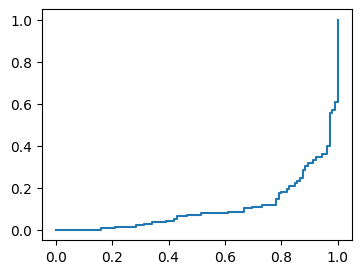

In [106]:
target = ['51-70','71-80','81-100']

# target = ['51-70 AD','71-80 AD','81-100 AD', '51-70 CN','71-80 CN','81-100 CN']
fig, c_ax = plt.subplots(1,1, figsize = (4, 3))
lb = LabelBinarizer()
lb.fit(y_test_new)
y_test = lb.transform(y_test_new)
# y_pred = lb.transform(y_pred)
# print(y_test)

for (idx, c_label) in enumerate(target):
    fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), np.array(preds_proba)[:,idx])
    # print(fpr, tpr, thresholds)
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, metrics.auc(fpr, tpr)))
    print(c_label, metrics.auc(fpr, tpr))
c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
c_ax.legend()
plt.show()

In [315]:
# mylabel = ['tAD age 51-70', 'tAD age 71-80', 'tAD age 81-100', 'tCN age 51-70', 'tCN age 71-80', 'tCN age 81-100', 'AD age 51-70', 'AD age 71-80', 'AD age 81-100', 'CN age 51-70', 'CN age 71-80', 'CN age 81-100']

In [340]:
# mylabel = ['AD age 51-70', 'AD age 71-80', 'AD age 81-100', 'CN age 51-70', 'CN age 71-80', 'CN age 81-100']
# mylabel = ['AD','CN']

In [52]:
rf = RandomForestClassifier(n_estimators=500, random_state=8042)
rf.fit(np.squeeze(x_train_new, axis = 1), y_train_new)
train_preds = rf.predict(np.squeeze(x_train_new, axis = 1))
preds = rf.predict(np.squeeze(x_test_new, axis = 1))
preds_proba = rf.predict_proba(np.squeeze(x_test_new, axis = 1))
accuracy_score(y_train_new, train_preds), accuracy_score(y_test_new, preds)

NameError: name 'x_train_new' is not defined

In [ ]:
silhouette_score(np.squeeze(np.append(np.array(x_val_new), np.array(x_test_new), axis = 0), axis = 1), 
                          np.append(np.array(y_val_new), np.array(np.squeeze(y_test_new)), axis=0))

0.04915305

In [168]:
silhouette_score(np.array(np.squeeze(x_train_new)), y_train_new)

0.20615022

In [181]:
silhouette_score(np.array(np.squeeze(x_test_new)), y_test_new)

0.1780342

In [148]:
silhouette_score(np.array(np.squeeze(x_val_new)), y_val_new)

0.10791444

[Text(0.5, 1.0, 'Siamese')]

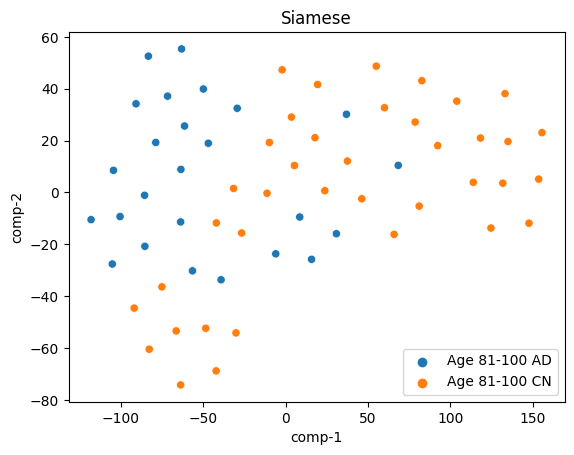

In [107]:
tsne = TSNE(random_state=8042)
# tsne_train = tsne.fit_transform(np.squeeze(np.append(np.array(x_val_new), np.array(x_test_new), axis = 0), axis = 1))
tsne_train = tsne.fit_transform(np.squeeze(np.array(x_test_new)))
df = pd.DataFrame()
# df["y"] = np.append(np.array(y_val_new), np.array(y_test_new), axis=0)
df["y"] = np.array(y_test_new)
df["comp-1"] = tsne_train[:,0]
df["comp-2"] = tsne_train[:,1]

plt.figure()
sn.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sn.color_palette("tab10"),
                data=df).set(title="Siamese")
# plt.legend(labels=mylabel, bbox_to_anchor=(1.5, 1.05))
# plt.savefig('../figure/siamese_proposed_fold_2_train.png')
# plt.savefig('../figure/siamese_fold_1_valtest.png')

[Text(0.5, 1.0, 'data T-SNE projection')]

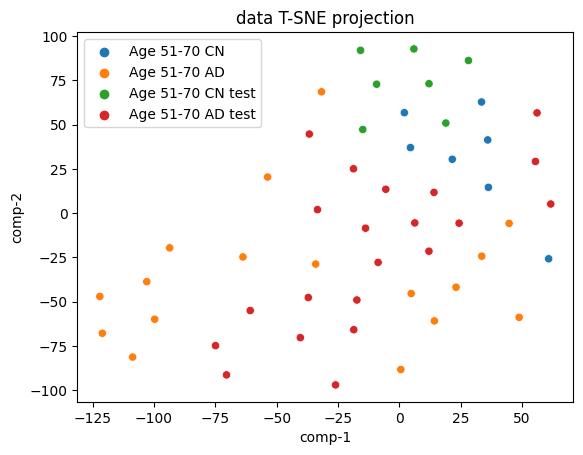

In [66]:
tsne = TSNE(random_state=8042)
tsne_train = tsne.fit_transform(np.squeeze(np.append(np.array(x_val_new), np.array(x_test_new), axis = 0), axis = 1))
# tsne_train = tsne.fit_transform(np.squeeze(np.array(x_test_new)))
df = pd.DataFrame()
df["y"] = np.append(np.array(y_val_new), np.array(y_test_new), axis=0)
# df["y"] = np.array(y_test_new)
df["comp-1"] = tsne_train[:,0]
df["comp-2"] = tsne_train[:,1]

plt.figure()
sn.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sn.color_palette("tab10"),
                data=df).set(title="Siamese")
# plt.legend(labels=mylabel, bbox_to_anchor=(1.5, 1.05))
# plt.savefig('../figure/siamese_proposed_fold_2_train.png')
# plt.savefig('../figure/siamese_fold_1_valtest.png')

[Text(0.5, 1.0, 'Proposed')]

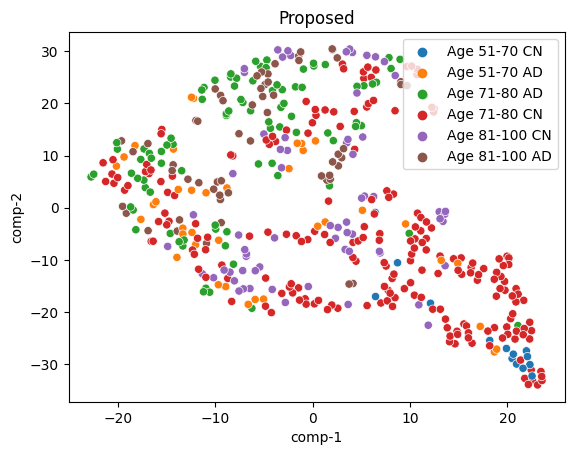

In [110]:
tsne = TSNE(random_state=8042)
tsne_train = tsne.fit_transform(np.squeeze(np.append(np.array(x_val_new), np.array(x_test_new), axis = 0), axis = 1))
# tsne_train = tsne.fit_transform(np.squeeze(np.array(x_test_new)))
df = pd.DataFrame()
df["y"] = np.append(np.array(y_val_new), np.array(y_test_new), axis=0)
# df["y"] = np.array(y_test_new)
df["comp-1"] = tsne_train[:,0]
df["comp-2"] = tsne_train[:,1]

plt.figure()
sn.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sn.color_palette("tab10"),
                data=df).set(title="Proposed")
# plt.legend(labels=mylabel, bbox_to_anchor=(1.5, 1.05))
# plt.savefig('../figure/siamese_proposed_fold_2_train.png')
# plt.savefig('../figure/siamese_fold_1_valtest.png')

[Text(0.5, 1.0, 'Proposed')]

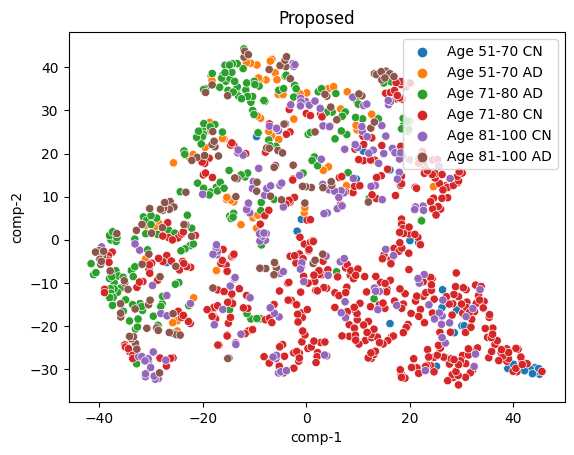

In [100]:
tsne = TSNE(random_state=8042)
# tsne_train = tsne.fit_transform(np.squeeze(np.append(np.array(x_val_new), np.array(x_test_new), axis = 0), axis = 1))
tsne_train = tsne.fit_transform(np.squeeze(np.array(x_train_new)))
df = pd.DataFrame()
# df["y"] = np.append(np.array(y_val_new), np.array(y_test_new), axis=0)
df["y"] = np.array(y_train_new)
df["comp-1"] = tsne_train[:,0]
df["comp-2"] = tsne_train[:,1]

plt.figure()
sn.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sn.color_palette("tab10"),
                data=df).set(title="Proposed")
# plt.legend(labels=mylabel, bbox_to_anchor=(1.5, 1.05))
# plt.savefig('../figure/siamese_proposed_fold_2_train.png')
# plt.savefig('../figure/siamese_fold_1_valtest.png')

# Classifier AD

In [43]:
# the dataset objects we prepared for you
wrapper = wrapper_val
dataset_train = tf.data.Dataset.from_tensor_slices((np.array(img_path_train), label_train))
dataset_train = dataset_train.map(wrapper, 
                      num_parallel_calls = tf.data.experimental.AUTOTUNE).map(_fixup_shape)
dataset_train = dataset_train.shuffle(BUFFER_SIZE)
dataset_train = dataset_train.batch(BATCH_SIZE, drop_remainder=True)
dataset_train = dataset_train.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

dataset_val = tf.data.Dataset.from_tensor_slices((np.array(img_path_val), label_val))
dataset_val = dataset_val.map(wrapper, num_parallel_calls=tf.data.experimental.AUTOTUNE).map(_fixup_shape)
dataset_val = dataset_val.batch(BATCH_SIZE, drop_remainder=True)

dataset_test = tf.data.Dataset.from_tensor_slices((np.array(img_path_test), label_test))
dataset_test = dataset_test.map(wrapper, num_parallel_calls=tf.data.experimental.AUTOTUNE).map(_fixup_shape)
dataset_test = dataset_test.batch(1, drop_remainder=True)

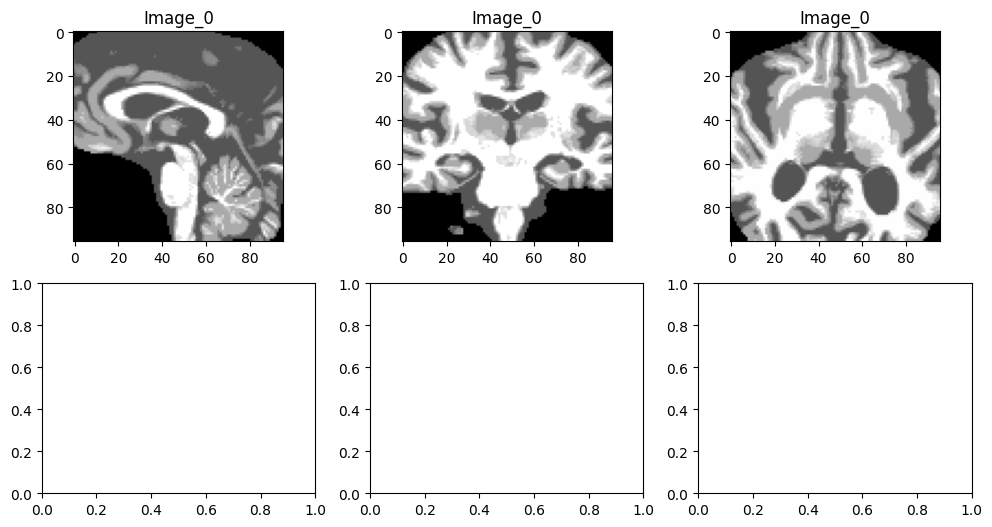

In [44]:
for img, label in dataset_val.take(1):
    # img, mask_img1, mask_img2 = inputs['inputImg'], inputs['inputMask1'], inputs['inputMask2']
    fig, ax = plt.subplots(2,3, figsize = (12, 6))
    ax[0][0].imshow(img[0][:,:,img[0].shape[2]//2], cmap='gray')
    ax[0][0].set_title('Image_0')
    ax[0][1].imshow(img[0][:,img[0].shape[1]//2, :], cmap='gray')
    ax[0][1].set_title('Image_0')
    ax[0][2].imshow(img[0][img[0].shape[0]//2], cmap='gray')
    ax[0][2].set_title('Image_0')
    # ax[0][0].imshow(mask_img1[0][:,:,mask_img1[0].shape[2]//2], cmap='gray', alpha=0.7)
    # ax[0][1].imshow(mask_img1[0][:,mask_img1[0].shape[1]//2, :], cmap='gray', alpha=0.7)
    # ax[0][2].imshow(mask_img1[0][mask_img1[0].shape[0]//2], cmap='gray', alpha=0.7)
    
    # ax[0][0].imshow(mask_img2[0][:,:,mask_img2[0].shape[2]//2], cmap='gray', alpha=0.7)
    # ax[0][1].imshow(mask_img2[0][:,mask_img2[0].shape[1]//2, :], cmap='gray', alpha=0.7)
    # ax[0][2].imshow(mask_img2[0][mask_img2[0].shape[0]//2], cmap='gray', alpha=0.7)

In [45]:
inputImg = keras.Input((IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_DEPTH, CHANNELS), name='inputImg')
# inputMask = keras.Input((IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_DEPTH), name='inputMask')
x = model(inputImg, training=False)
# z = layers.LeakyReLU(alpha=0.01)(x)
#z = Dense(units=512, activation='relu')(x)
# z = layers.LeakyReLU(alpha=0.01)(z)
#z = Dropout(0.4)(z)
z = Dense(units=64, activation='relu')(x)
# z = layers.LeakyReLU(alpha=0.01)(z)
# z = layers.Dropout(0.3)(z)

outputs = Dense(units=2, activation="softmax")(z)

full_model = keras.Model(inputs=[inputImg], outputs=outputs, name="3dcnn")
model.trainable = False

In [46]:
full_model.summary()

Model: "3dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputImg (InputLayer)        [(None, 96, 96, 96, 1)]   0         
_________________________________________________________________
model (Functional)           (None, 64)                33203648  
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
Total params: 33,207,938
Trainable params: 4,290
Non-trainable params: 33,203,648
_________________________________________________________________


## Training

In [47]:
initial_learning_rate = 0.001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.9, staircase=True
)

full_model.compile(
    loss="sparse_categorical_crossentropy",
    # optimizer=keras.optimizers.Adagrad(learning_rate=initial_learning_rate),
    # optimizer=keras.optimizers.SGD(lr=initial_learning_rate, momentum=0.9),
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["accuracy"],
)

# # Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "./retrain/siamese_proposed_gender_fold_" + fold + "_2.h5", save_best_only=True, monitor='val_accuracy', mode='max'
)

callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_loss',patience=15),
                  keras.callbacks.ModelCheckpoint(filepath='./retrain/siamese_proposed_gender_fold_' + fold + '_2.h5',monitor='val_loss',save_best_only=True,)]

In [48]:
epochs = 30
history = full_model.fit(
    dataset_train,
    validation_data=dataset_val, 
    epochs=epochs,
    verbose=1,
    callbacks=callbacks_list,
)

Epoch 1/30
170/170 [==============================] - 37s 92ms/step - loss: 1.9627 - accuracy: 0.6647 - val_loss: 1.9185 - val_accuracy: 0.8034
Epoch 2/30
170/170 [==============================] - 35s 88ms/step - loss: 1.8511 - accuracy: 0.8118 - val_loss: 1.8332 - val_accuracy: 0.8120
Epoch 3/30
170/170 [==============================] - 34s 87ms/step - loss: 1.7734 - accuracy: 0.8304 - val_loss: 1.8245 - val_accuracy: 0.8333
Epoch 4/30
170/170 [==============================] - 34s 86ms/step - loss: 1.7486 - accuracy: 0.8441 - val_loss: 1.8222 - val_accuracy: 0.8120
Epoch 5/30
170/170 [==============================] - 34s 88ms/step - loss: 1.7421 - accuracy: 0.8392 - val_loss: 1.8315 - val_accuracy: 0.8333
Epoch 6/30
170/170 [==============================] - 34s 88ms/step - loss: 1.7350 - accuracy: 0.8451 - val_loss: 1.8399 - val_accuracy: 0.8376
Epoch 7/30
170/170 [==============================] - 34s 88ms/step - loss: 1.7370 - accuracy: 0.8461 - val_loss: 1.8356 - val_accuracy:

# Classifier Demographic

In [438]:
# the dataset objects we prepared for you
now = 'age'
wrapper = wrapper_val
dataset_train = tf.data.Dataset.from_tensor_slices((np.array(img_path_train), label_age_train))
dataset_train = dataset_train.map(wrapper, 
                      num_parallel_calls = tf.data.experimental.AUTOTUNE).map(_fixup_shape)
dataset_train = dataset_train.shuffle(BUFFER_SIZE)
dataset_train = dataset_train.batch(BATCH_SIZE, drop_remainder=True)
dataset_train = dataset_train.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

dataset_val = tf.data.Dataset.from_tensor_slices((np.array(img_path_val), label_age_val))
dataset_val = dataset_val.map(wrapper, num_parallel_calls=tf.data.experimental.AUTOTUNE).map(_fixup_shape)
dataset_val = dataset_val.batch(BATCH_SIZE, drop_remainder=True)

dataset_test = tf.data.Dataset.from_tensor_slices((np.array(img_path_test), label_age_test))
dataset_test = dataset_test.map(wrapper, num_parallel_calls=tf.data.experimental.AUTOTUNE).map(_fixup_shape)
dataset_test = dataset_test.batch(1, drop_remainder=True)

In [439]:
# # the dataset objects we prepared for you
# now = 'sex'
# wrapper = wrapper_val
# dataset_train = tf.data.Dataset.from_tensor_slices((np.array(img_path_train), sex_train))
# dataset_train = dataset_train.map(wrapper, 
#                       num_parallel_calls = tf.data.experimental.AUTOTUNE).map(_fixup_shape)
# dataset_train = dataset_train.shuffle(BUFFER_SIZE)
# dataset_train = dataset_train.batch(BATCH_SIZE, drop_remainder=True)
# dataset_train = dataset_train.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# dataset_val = tf.data.Dataset.from_tensor_slices((np.array(img_path_val), sex_val))
# dataset_val = dataset_val.map(wrapper, num_parallel_calls=tf.data.experimental.AUTOTUNE).map(_fixup_shape)
# dataset_val = dataset_val.batch(BATCH_SIZE, drop_remainder=True)

# dataset_test = tf.data.Dataset.from_tensor_slices((np.array(img_path_test), sex_test))
# dataset_test = dataset_test.map(wrapper, num_parallel_calls=tf.data.experimental.AUTOTUNE).map(_fixup_shape)
# dataset_test = dataset_test.batch(1, drop_remainder=True)

tf.Tensor(
[[0]
 [0]
 [0]
 [0]
 [0]
 [0]], shape=(6, 1), dtype=int32)


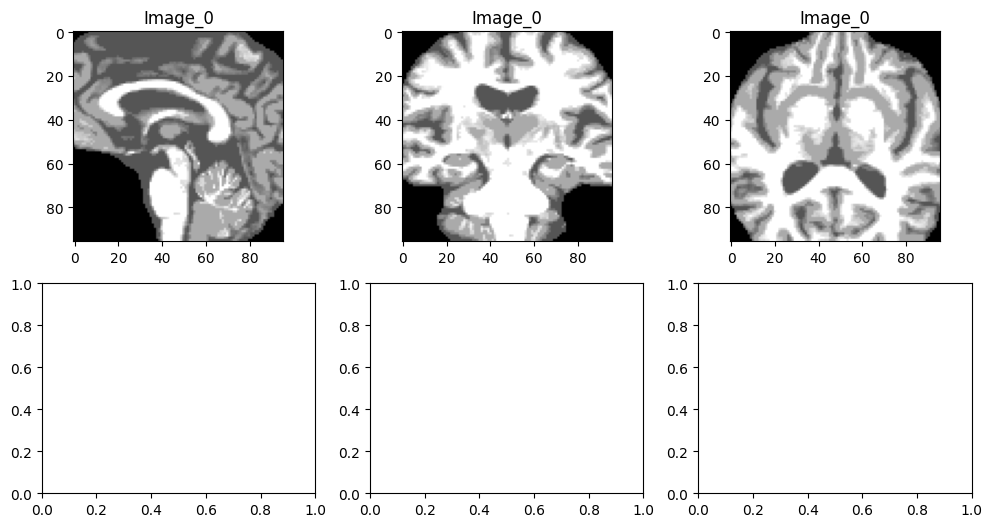

In [440]:
for img, label in dataset_val.take(1):
    fig, ax = plt.subplots(2,3, figsize = (12, 6))
    ax[0][0].imshow(img[0][:,:,img[0].shape[2]//2], cmap='gray')
    ax[0][0].set_title('Image_0')
    ax[0][1].imshow(img[0][:,img[0].shape[1]//2, :], cmap='gray')
    ax[0][1].set_title('Image_0')
    ax[0][2].imshow(img[0][img[0].shape[0]//2], cmap='gray')
    ax[0][2].set_title('Image_0')
    print(label)
    # ax[0][0].imshow(mask_img1[0][:,:,mask_img1[0].shape[2]//2], cmap='gray', alpha=0.7)
    # ax[0][1].imshow(mask_img1[0][:,mask_img1[0].shape[1]//2, :], cmap='gray', alpha=0.7)
    # ax[0][2].imshow(mask_img1[0][mask_img1[0].shape[0]//2], cmap='gray', alpha=0.7)
    
    # ax[0][0].imshow(mask_img2[0][:,:,mask_img2[0].shape[2]//2], cmap='gray', alpha=0.7)
    # ax[0][1].imshow(mask_img2[0][:,mask_img2[0].shape[1]//2, :], cmap='gray', alpha=0.7)
    # ax[0][2].imshow(mask_img2[0][mask_img2[0].shape[0]//2], cmap='gray', alpha=0.7)

In [441]:
inputImg = keras.Input((IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_DEPTH, CHANNELS), name='inputImg')
# inputMask = keras.Input((IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_DEPTH), name='inputMask')
x = model(inputImg, training=False)
# z = layers.LeakyReLU(alpha=0.01)(x)
#z = Dense(units=512, activation='relu')(x)
# z = layers.LeakyReLU(alpha=0.01)(z)
#z = Dropout(0.4)(z)
z = Dense(units=64, activation='relu')(x)
# z = layers.LeakyReLU(alpha=0.01)(z)
# z = layers.Dropout(0.3)(z)

if now == 'age':
    outputs = Dense(units=3, activation="softmax")(z)
else: 
    outputs = Dense(units=1, activation="sigmoid")(z)
    
full_model = keras.Model(inputs=[inputImg], outputs=outputs, name="3dcnn")
model.trainable = False

In [442]:
full_model.summary()

Model: "3dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputImg (InputLayer)        [(None, 96, 96, 96, 1)]   0         
_________________________________________________________________
model_6 (Functional)         (None, 64)                33203648  
_________________________________________________________________
dense_31 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_32 (Dense)             (None, 3)                 195       
Total params: 33,208,003
Trainable params: 4,355
Non-trainable params: 33,203,648
_________________________________________________________________


## Training

In [443]:
initial_learning_rate = 0.01
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.9, staircase=True
)

if now == 'age':
    full_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["sparse_categorical_accuracy"])
else:
    full_model.compile(
        loss="binary_crossentropy",
        optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
        metrics=[tf.keras.metrics.AUC(), "accuracy"]
    )

callbacks_list = [keras.callbacks.EarlyStopping(monitor='loss',patience=10),
                  keras.callbacks.ModelCheckpoint(filepath='./gender/siamese_proposed_gender_fold_' + fold + '.h5',monitor='val_loss',save_best_only=True,)]


In [444]:
# epochs = 50
# history = full_model.fit(
#     dataset_train,
#     validation_data=dataset_val, 
#     epochs=epochs,
#     verbose=1,
#     callbacks=callbacks_list,
# )

In [445]:
label_age_train[0]

array([0])

# Initialize

In [167]:
acc_gender = []
acc_age = []
gender = []
age = []
for t in range(3):
    age.append([])

# Evaluate

In [446]:
if now == 'sex':
    full_model.load_weights('./gender/siamese_proposed_gender_fold_' + fold + '.h5')
else:
    full_model.load_weights('./age/siamese_proposed_age_fold_' + fold + '.h5')

In [447]:
# full_model.evaluate(dataset_test)

In [448]:
y_pred = []
y_true = []
for img, label in tqdm(dataset_test):
    # pred = model.predict(masked_img)
    # print(pred.shape)
    # print(pred)
    for each in full_model.predict(img):
        y_pred.append(each)
    for each in label.numpy():
        y_true.append(each[0])
    # break

100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:16<00:00, 12.62it/s]


In [449]:
y_pred_one_label = []
for each in y_pred:
    if now == 'age':
        y_pred_one_label.append(np.argmax(each))
    else:
        y_pred_one_label.append(1 if each >= 0.5 else 0)

In [450]:
y_pred_one_label[:10]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [451]:
y_pred[:10]

[array([0.04752479, 0.7394885 , 0.21298666], dtype=float32),
 array([0.04960117, 0.67394274, 0.2764561 ], dtype=float32),
 array([0.04777841, 0.686304  , 0.2659176 ], dtype=float32),
 array([0.08484267, 0.57507795, 0.34007943], dtype=float32),
 array([0.16099362, 0.509746  , 0.32926032], dtype=float32),
 array([0.13457975, 0.5307077 , 0.3347125 ], dtype=float32),
 array([0.08230146, 0.57706493, 0.3406336 ], dtype=float32),
 array([0.0536881 , 0.658444  , 0.28786787], dtype=float32),
 array([0.11912806, 0.5439691 , 0.33690286], dtype=float32),
 array([0.12358312, 0.5402678 , 0.3361491 ], dtype=float32)]

In [452]:
cm = confusion_matrix(y_true, y_pred_one_label)
cm

array([[  5,  17,   0],
       [  1, 128,   0],
       [  0,  63,   0]], dtype=int64)

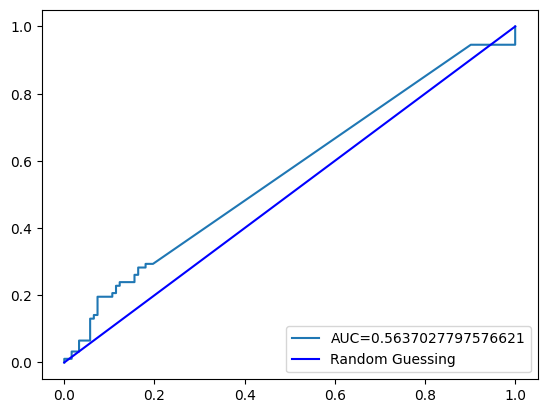

acc: 0.5887850467289719


In [437]:
auc = roc_auc_score(y_true, np.array(y_pred))
fpr, tpr, thresholds_keras = roc_curve(y_true,  np.array(y_pred))
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.plot(fpr, fpr, 'b-', label = 'Random Guessing')
plt.legend(loc=4)
plt.show()
gender.append(auc)
print('acc: {}'.format(accuracy_score(y_true, y_pred_one_label)))
acc_gender.append(accuracy_score(y_true, y_pred_one_label))

Age_51-70 0.6273674242424242
Age_71-80 0.7018239854081167
Age_81-100 0.6253022180174498
acc: 0.6214953271028038


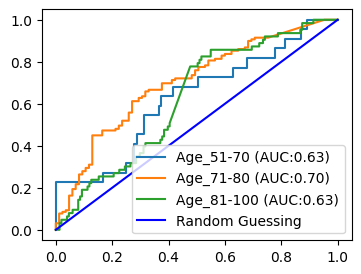

In [453]:
target = ['Age_51-70', 'Age_71-80','Age_81-100']
fig, c_ax = plt.subplots(1,1, figsize = (4, 3))
lb = LabelBinarizer()
lb.fit(y_true)
y_test = lb.transform(y_true)
for (idx, c_label) in enumerate(target):
    fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), np.array(y_pred)[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, metrics.auc(fpr, tpr)))
    print(c_label, metrics.auc(fpr, tpr))
    age[idx].append(metrics.auc(fpr, tpr))
print('acc: {}'.format(accuracy_score(y_true, y_pred_one_label)))
c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
c_ax.legend()
plt.show()
acc_age.append(accuracy_score(y_true, y_pred_one_label))

In [454]:
age, gender, acc_age, acc_gender

([[0.6966321243523316,
   0.42906976744186043,
   0.6432850241545894,
   0.6030245746691871,
   0.6273674242424242],
  [0.6940048408117668,
   0.6736070381231672,
   0.6140148011100833,
   0.6565079365079365,
   0.7018239854081167],
  [0.6425977355265968,
   0.7561020036429872,
   0.5931359473637414,
   0.6604706528706163,
   0.6253022180174498]],
 [0.4990223960184856,
  0.6862663906142167,
  0.5242805086636424,
  0.6156899810964083,
  0.5637027797576621],
 [0.6150234741784038,
  0.6378600823045267,
  0.5948275862068966,
  0.6086956521739131,
  0.6214953271028038],
 [0.5586854460093896,
  0.5925925925925926,
  0.5043103448275862,
  0.5695652173913044,
  0.5887850467289719])

# to_csv

In [455]:
avg_age = np.mean((age[0], age[1], age[2]), axis = 0)
avg_age

array([0.6777449 , 0.61959294, 0.61681192, 0.64000105, 0.65149788])

In [457]:
df_csv = pd.DataFrame({'acc_age':acc_age, 'acc_gender':acc_gender, 'gender':gender, 'Age_51-70':age[0], 'Age_71-80':age[1], 'Age_81-100':age[2], 'avg_age':avg_age})

df_csv.to_csv('..//..//../result3D/demographic/siamese.csv', index=False)